In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [76]:
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [77]:
df = pd.read_excel('energy_dataset.xlsx')

In [78]:
df1= pd.read_excel('weather_features.xlsx')

**Drop City Name**

In [79]:
df1 =  df1.drop(columns=['city_name'])

In [80]:
aggregated_df = df1.groupby('dt_iso').agg({
    'temp' : 'mean',
    'temp_min' 	: 'mean',
    'temp_max'	: 'mean',
    'pressure'	: 'mean',
    'humidity'	: 'mean',
    'wind_speed' :	'mean',
    'wind_deg'	: 'mean',
    'rain_1h'	: 'mean',
    'rain_3h'	: 'mean',
    'snow_3h'	: 'mean',
    'clouds_all' :	'mean',
    'weather_id'	: lambda x: x.mode()[0],
    'weather_main' :	lambda x: x.mode()[0],
    'weather_description' : lambda x: x.mode()[0],
    'weather_icon' : lambda x: x.mode()[0],
    }
).reset_index()

<ipython-input-80-4d750ef237b2>:16: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  'weather_icon' : lambda x: x.mode()[0],
<ipython-input-80-4d750ef237b2>:16: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  'weather_icon' : lambda x: x.mode()[0],


In [81]:
aggregated_df.head()

dt_iso        temp    temp_min    temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  272.491463  272.491463  272.491463    1016.4   
1  2015-01-01 01:00:00+01:00  272.512700  272.512700  272.512700    1016.2   
2  2015-01-01 02:00:00+01:00  272.099137  272.099137  272.099137    1016.8   
3  2015-01-01 03:00:00+01:00  272.089469  272.089469  272.089469    1016.6   
4  2015-01-01 04:00:00+01:00  272.145900  272.145900  272.145900    1016.6   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0      82.4         2.0     135.2      0.0      0.0      0.0         0.0   
1      82.4         2.0     135.8      0.0      0.0      0.0         0.0   
2      82.0         2.4     119.0      0.0      0.0      0.0         0.0   
3      82.0         2.4     119.2      0.0      0.0      0.0         0.0   
4      82.0         2.4     118.4      0.0      0.0      0.0         0.0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

**Convert the date columns to datetime format**


In [82]:
aggregated_df['dt_iso'] = pd.to_datetime(aggregated_df['dt_iso'], utc=True)
df['time'] = pd.to_datetime(df['time'], utc=True)

**Merge the datasets on the common datetime column**


In [83]:
merged_df = pd.merge(df, aggregated_df, left_on='time', right_on='dt_iso')

In [84]:
merged_df.to_csv('merged_data.csv', index=False)

**Drop the extra 'dt_iso' column after merging**


In [85]:
merged_df =  merged_df.drop(columns=['dt_iso'])

In [86]:
merged_df.shape

(35064, 44)

In [87]:
merged_df.head()

time  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0  ...         2.0     135.2      0.0      0.0      0.0         0.0   
1  ...         2.0     135.8      0.0      0.0      0.0         0.0   
2  ...         2.4     119.0      0.0      0.0      0.0         0.0   
3  ...         2.4     119.2      0.0      0.0      0.0         0.0   
4  ...         2.4     118.4      0.0      0.0      0.0         0.0   

   weather_id  weather_main  weather_description  weather_icon  
0         800         clear         sky is clear           01n  
1         800         clear         sky is clear           01n  
2         800         clear         sky is clear           01n  
3         800         clear         sky is clear           01n  
4         800         clear         sky is clear           01n  

[5 rows x 44 columns]

In [88]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 44 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil coal-derived gas           35046 non-null  float64            
 4   generation fossil gas                        35046 non-null  float64            
 5   generation fossil hard coal                  35046 non-null  float64            
 6   generation fossil oil                        35045 non-null  float64            
 7   generation fossil oil shale                  35046 non-null  float64            
 8   generation fossil peat    

In [89]:
merged_df.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [90]:
merged_df.drop(columns="generation hydro pumped storage aggregated", inplace=True)

In [91]:
merged_df.drop(columns="forecast wind offshore eday ahead", inplace=True)


In [92]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 42 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil coal-derived gas           35046 non-null  float64            
 4   generation fossil gas                        35046 non-null  float64            
 5   generation fossil hard coal                  35046 non-null  float64            
 6   generation fossil oil                        35045 non-null  float64            
 7   generation fossil oil shale                  35046 non-null  float64            
 8   generation fossil peat    

In [93]:
merged_df =  merged_df.drop(columns=['generation fossil coal-derived gas',
                                       'generation fossil oil shale',
                                       'generation fossil peat',
                                       'generation geothermal',
                                       'generation marine',
                                       'generation wind offshore',
                                       ])

In [94]:
merged_df.shape

(35064, 36)

In [95]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil gas                        35046 non-null  float64            
 4   generation fossil hard coal                  35046 non-null  float64            
 5   generation fossil oil                        35045 non-null  float64            
 6   generation hydro pumped storage consumption  35045 non-null  float64            
 7   generation hydro run-of-river and poundage   35045 non-null  float64            
 8   generation hydro water res

In [96]:
merged_df.head()

time  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   
3                                 254.0                 4314.0   
4                                 187.0                 4130.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.0   
1                       4755.0                  158.0   
2                       4581.0                  157.0   
3                       4131.0                  160.0   
4                       3840.0                  156.0   

   generation hydro pumped storage consumption  \
0                                        863.0   
1                                        920.0   
2                                       1164.0   
3                                       1503.0   
4                                       1826.0   

   generation hydro run-of-river and poundage  \
0                                      1051.0   
1                                      1009.0   
2                                       973.0   
3                                       949.0   
4                                       953.0   

   generation hydro water reservoir  generation nuclear  ...  wind_speed  \
0                            1899.0              7096.0  ...         2.0   
1                            1658.0              7096.0  ...         2.0   
2                            1371.0              7099.0  ...         2.4   
3                             779.0              7098.0  ...         2.4   
4                             720.0              7097.0  ...         2.4   

   wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  weather_id  weather_main  \
0     135.2      0.0      0.0      0.0         0.0         800         clear   
1     135.8      0.0      0.0      0.0         0.0         800         clear   
2     119.0      0.0      0.0      0.0         0.0         800         clear   
3     119.2      0.0      0.0      0.0         0.0         800         clear   
4     118.4      0.0      0.0      0.0         0.0         800         clear   

   weather_description  weather_icon  
0         sky is clear           01n  
1         sky is clear           01n  
2         sky is clear           01n  
3         sky is clear           01n  
4         sky is clear           01n  

[5 rows x 36 columns]

In [97]:
merged_df.shape

(35064, 36)

In [98]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil gas                        35046 non-null  float64            
 4   generation fossil hard coal                  35046 non-null  float64            
 5   generation fossil oil                        35045 non-null  float64            
 6   generation hydro pumped storage consumption  35045 non-null  float64            
 7   generation hydro run-of-river and poundage   35045 non-null  float64            
 8   generation hydro water res

In [99]:
merged_df.head()

time  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   
3                                 254.0                 4314.0   
4                                 187.0                 4130.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.0   
1                       4755.0                  158.0   
2                       4581.0                  157.0   
3                       4131.0                  160.0   
4                       3840.0                  156.0   

   generation hydro pumped storage consumption  \
0                                        863.0   
1                                        920.0   
2                                       1164.0   
3                                       1503.0   
4                                       1826.0   

   generation hydro run-of-river and poundage  \
0                                      1051.0   
1                                      1009.0   
2                                       973.0   
3                                       949.0   
4                                       953.0   

   generation hydro water reservoir  generation nuclear  ...  wind_speed  \
0                            1899.0              7096.0  ...         2.0   
1                            1658.0              7096.0  ...         2.0   
2                            1371.0              7099.0  ...         2.4   
3                             779.0              7098.0  ...         2.4   
4                             720.0              7097.0  ...         2.4   

   wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  weather_id  weather_main  \
0     135.2      0.0      0.0      0.0         0.0         800         clear   
1     135.8      0.0      0.0      0.0         0.0         800         clear   
2     119.0      0.0      0.0      0.0         0.0         800         clear   
3     119.2      0.0      0.0      0.0         0.0         800         clear   
4     118.4      0.0      0.0      0.0         0.0         800         clear   

   weather_description  weather_icon  
0         sky is clear           01n  
1         sky is clear           01n  
2         sky is clear           01n  
3         sky is clear           01n  
4         sky is clear           01n  

[5 rows x 36 columns]

In [100]:
merged_df.shape

(35064, 36)

In [101]:
merged_df.isnull().sum()

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0


In [102]:
df["total load actual"].mean()

28696.93990521868

In [103]:
merged_df["total load actual"].fillna(df["total load actual"].mean(), inplace=True)

In [104]:
merged_df['generation biomass'].value_counts()

generation biomass
361.0    321
362.0    318
351.0    310
358.0    305
359.0    305
        ... 
101.0      1
589.0      1
174.0      1
175.0      1
168.0      1
Name: count, Length: 423, dtype: int64

In [105]:
numerical_cols = merged_df.select_dtypes(include=np.number).columns
merged_df[numerical_cols] = merged_df[numerical_cols].fillna(merged_df[numerical_cols].mean())


In [106]:
merged_df.isnull().sum()
merged_df.shape

(35064, 36)

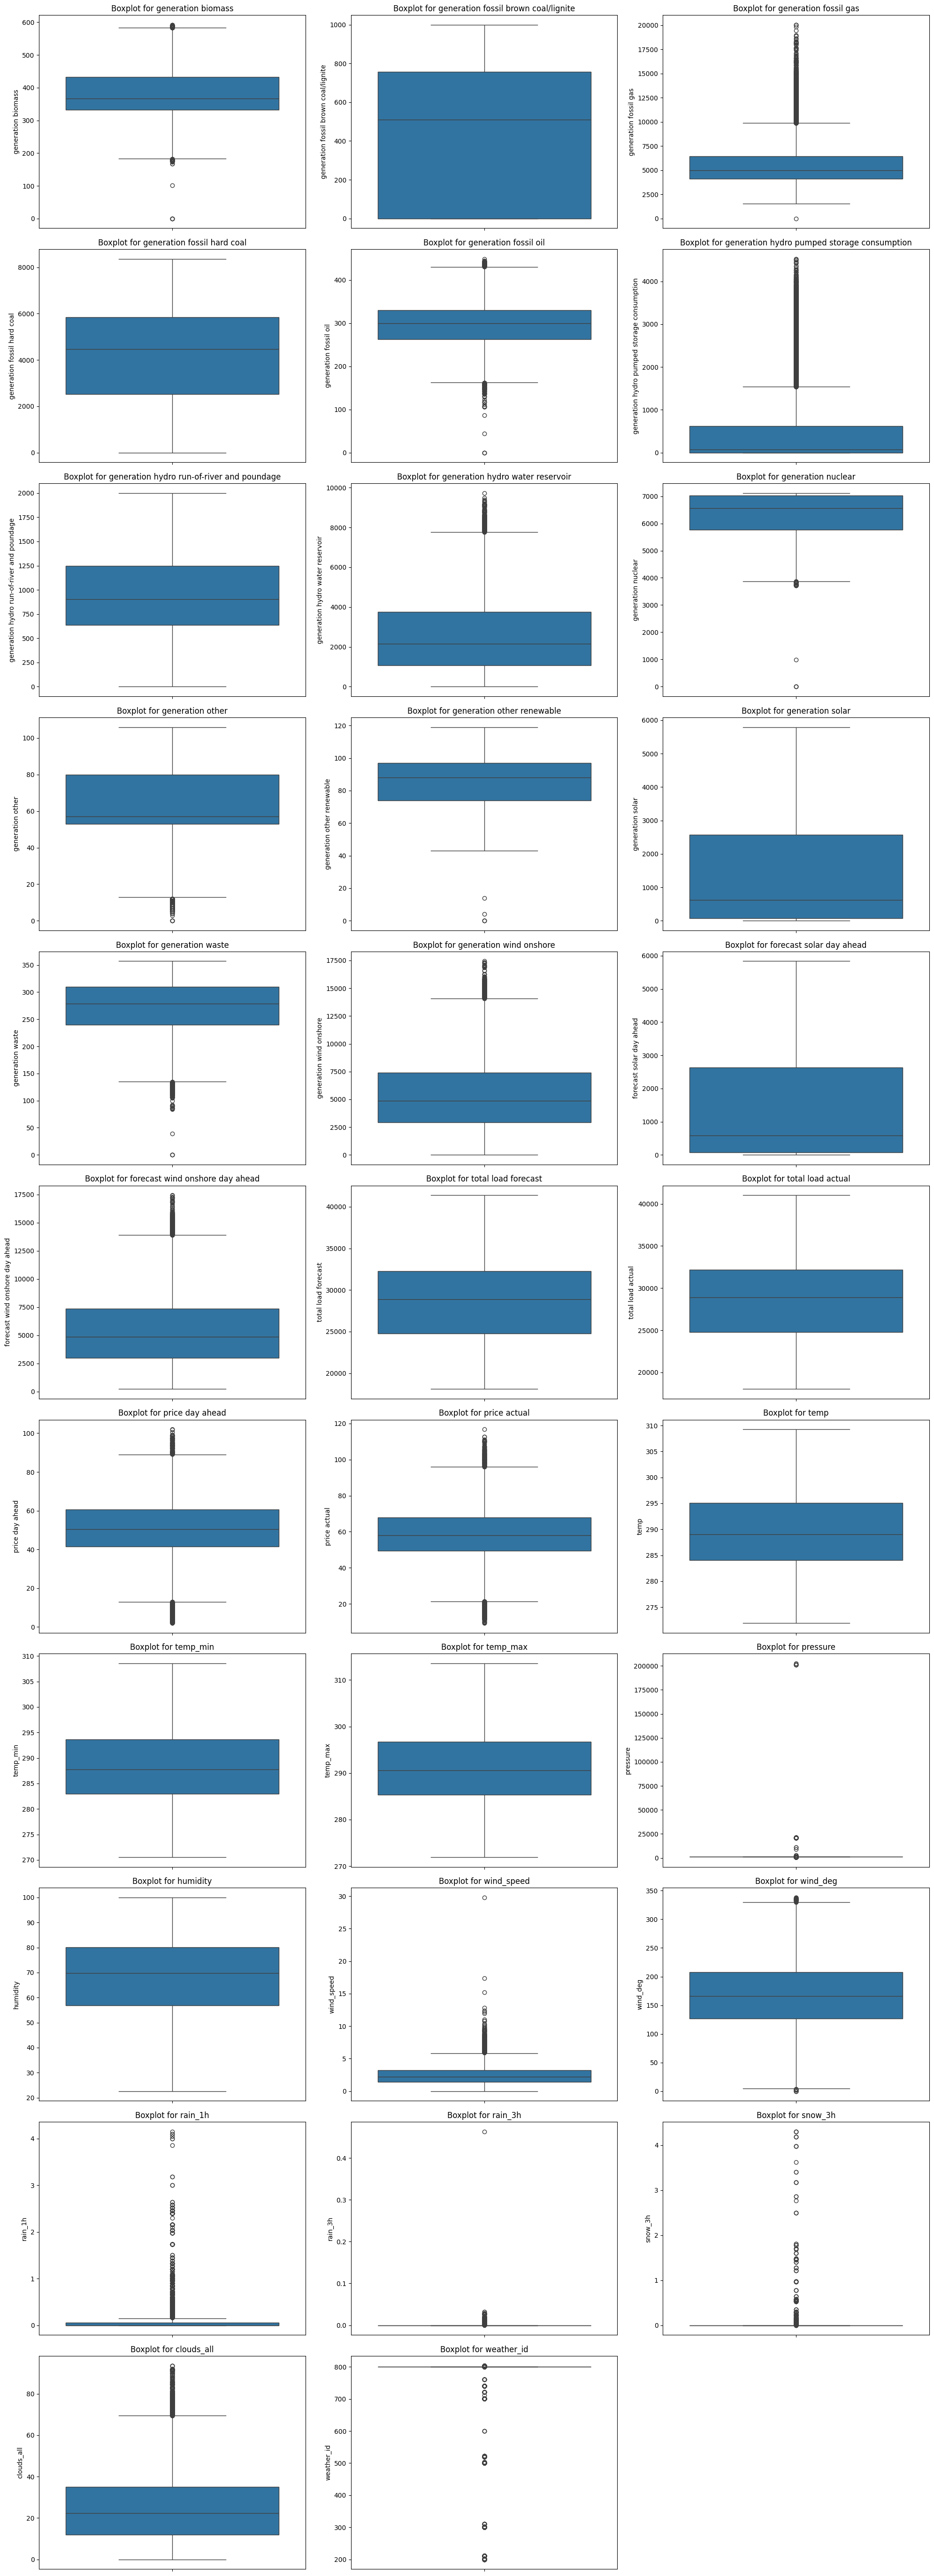

In [107]:
# Create subplots for boxplots
def plot_boxplots(df, columns):
    n_cols = 3
    n_rows = int(np.ceil(len(columns) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.boxplot(df[col], ax=axes[i])
        axes[i].set_title(f'Boxplot for {col}')

    # Remove any empty subplots
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Plot boxplots for numerical columns
plot_boxplots(merged_df, numerical_cols)

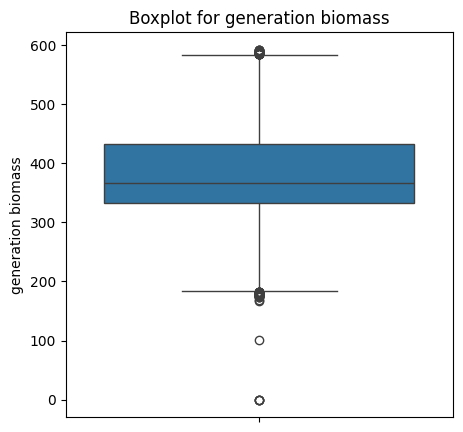

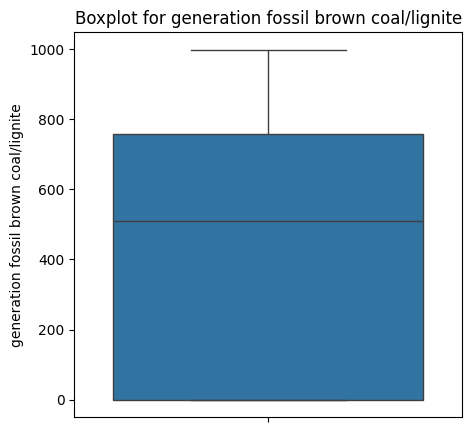

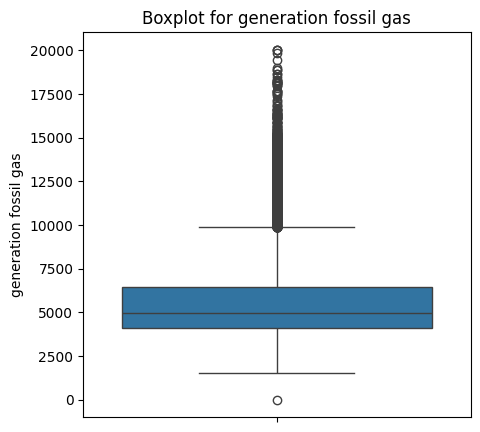

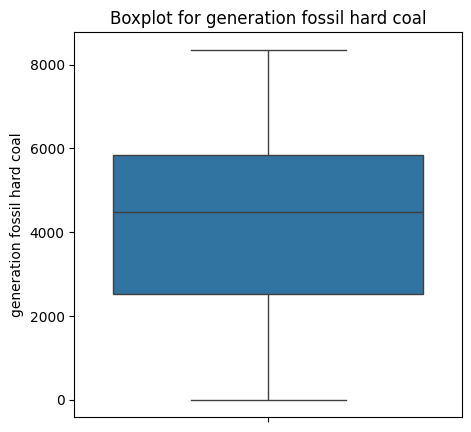

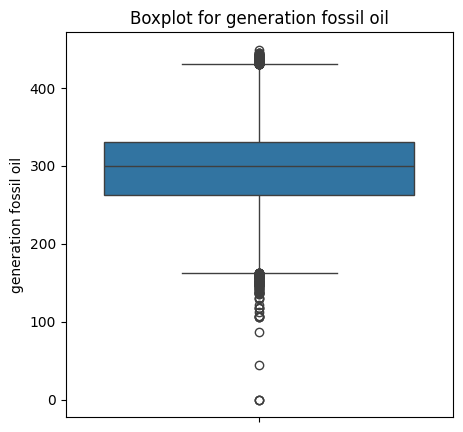

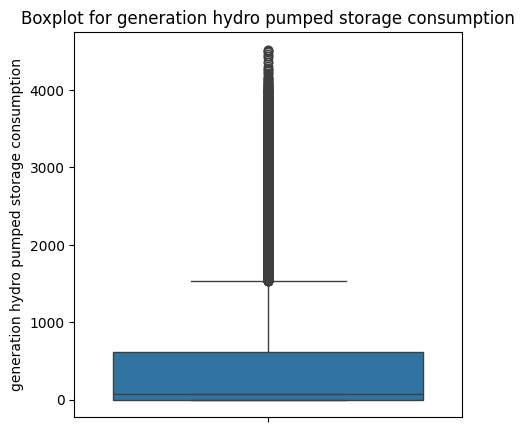

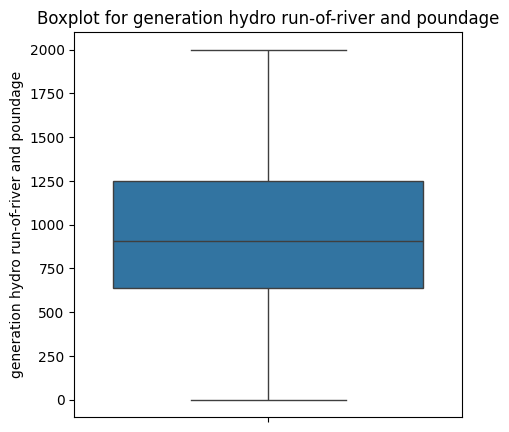

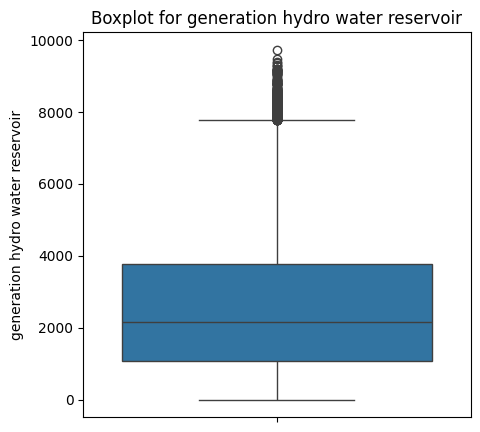

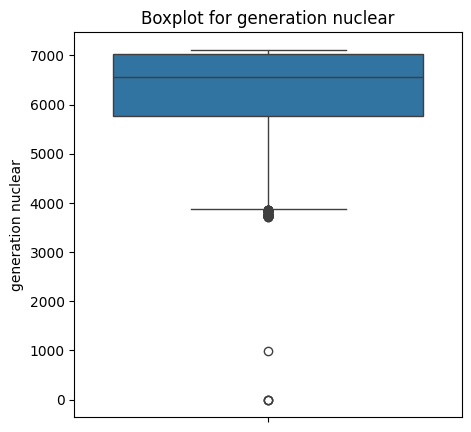

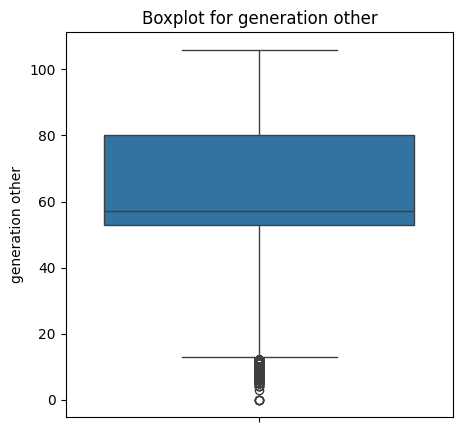

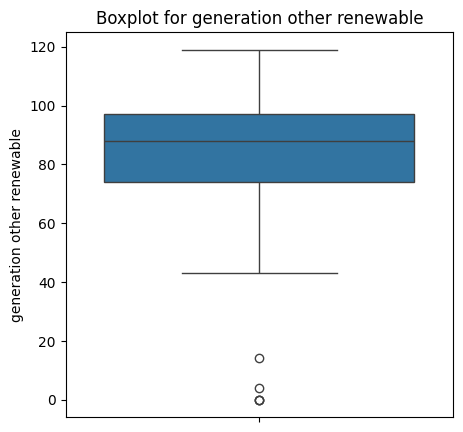

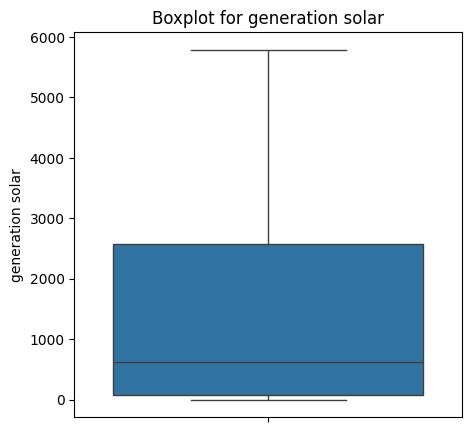

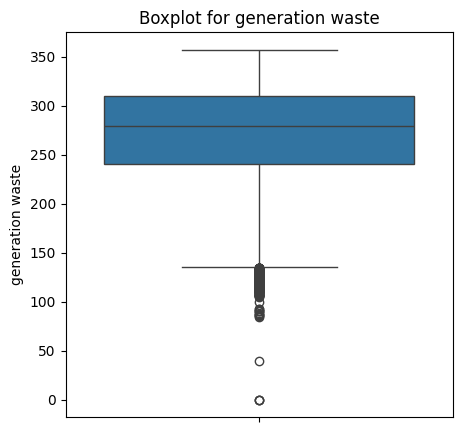

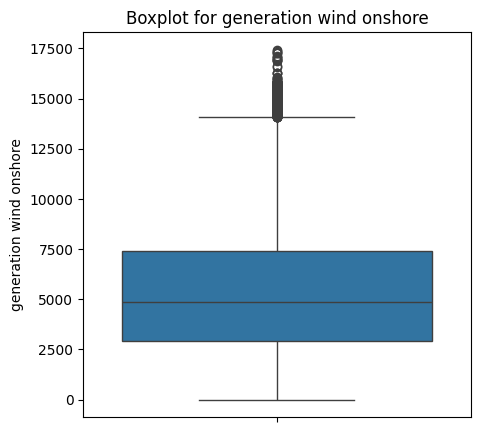

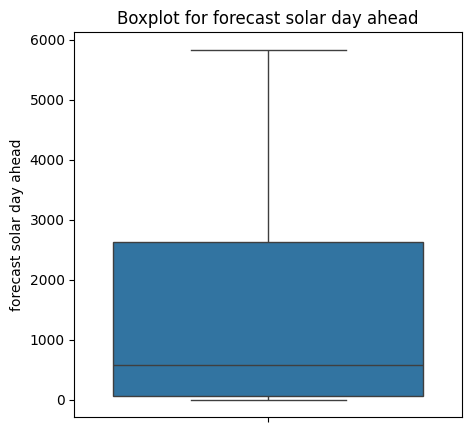

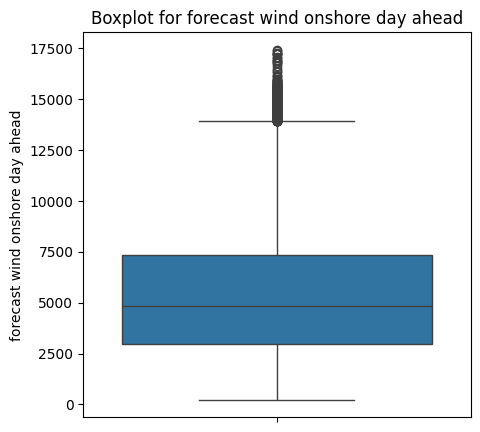

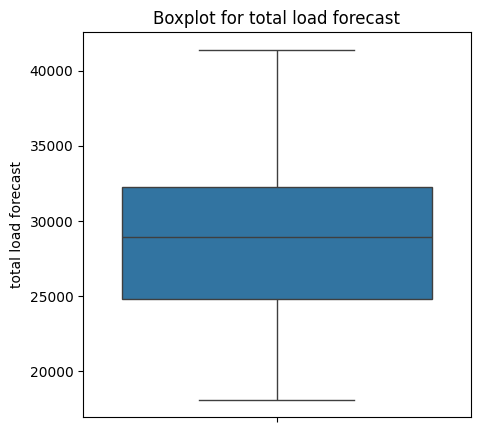

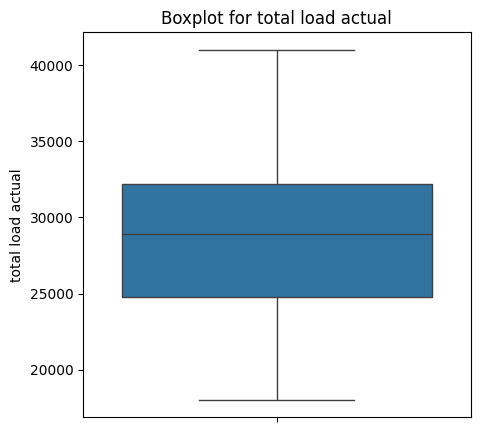

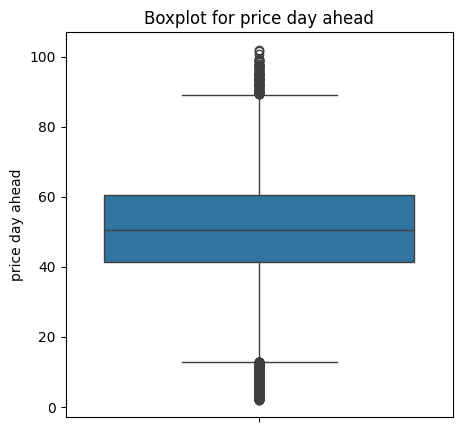

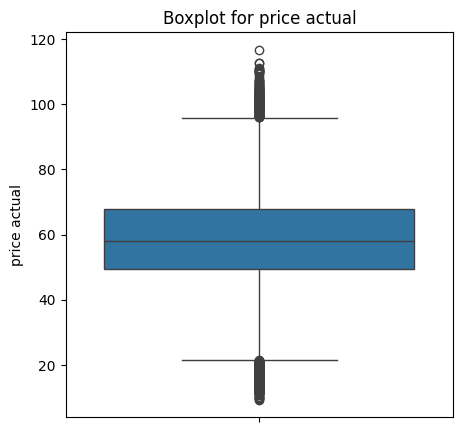

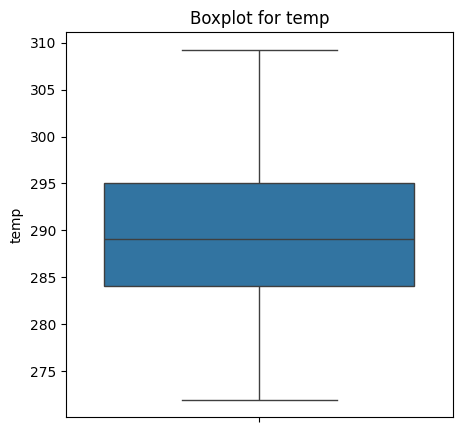

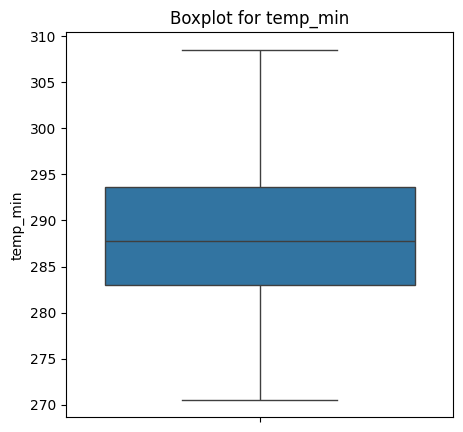

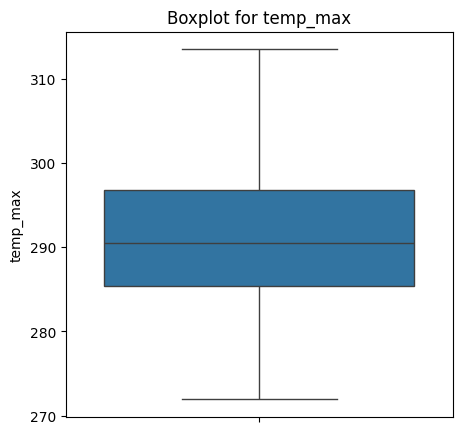

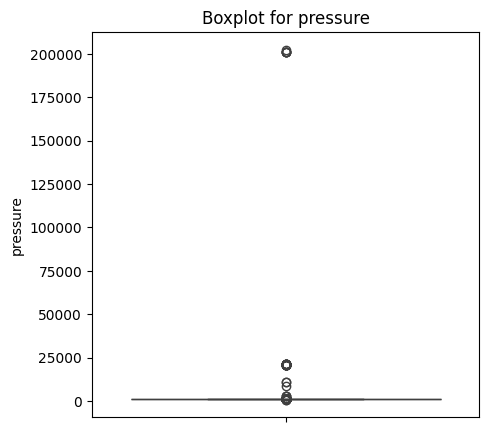

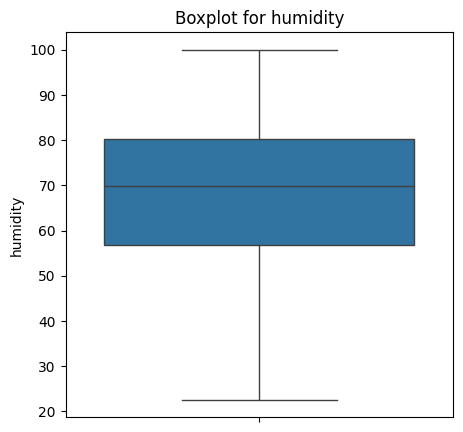

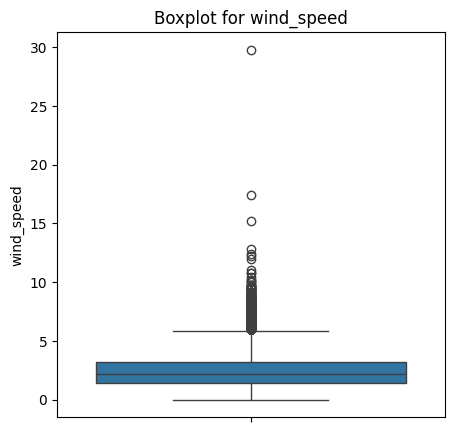

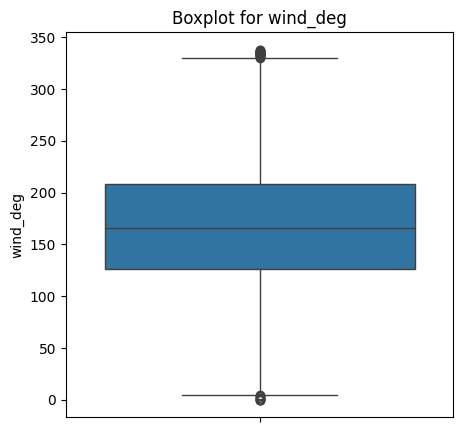

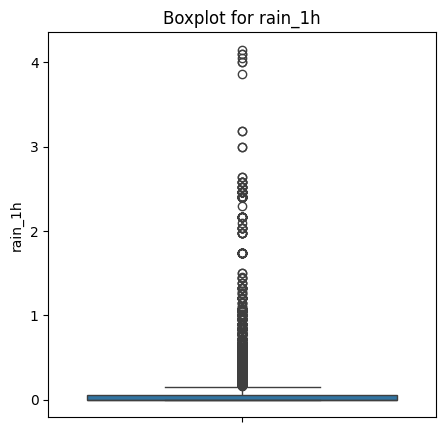

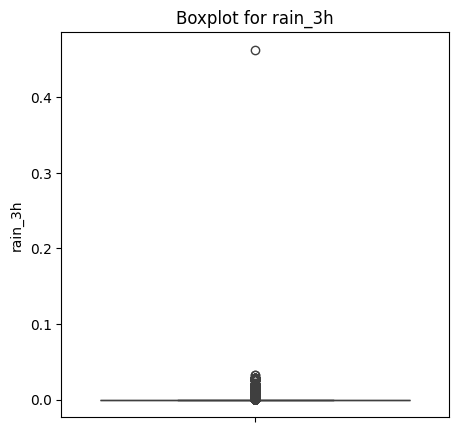

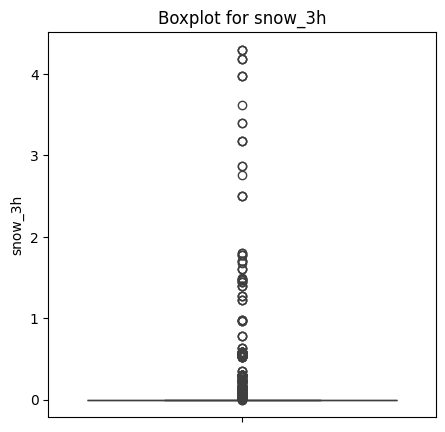

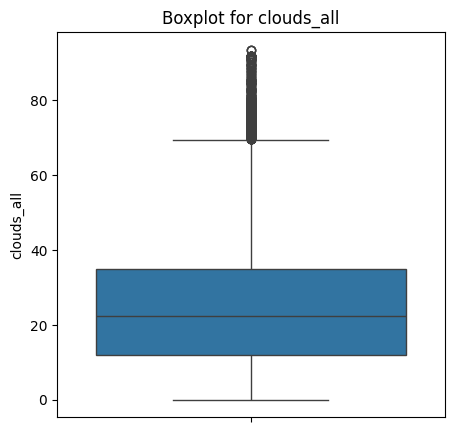

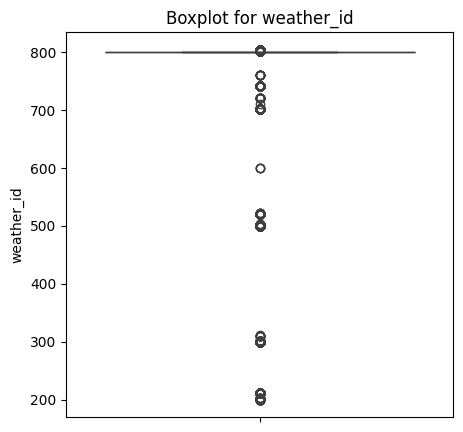

In [108]:
# Boxplot for outliers visualization
def plot_boxplots(df, columns):
    for col in columns:
        plt.figure(figsize=(5, 5))
        sns.boxplot(df[col])
        plt.title(f'Boxplot for {col}')
        plt.show()

# Plot boxplots for numerical columns
plot_boxplots(merged_df, numerical_cols)

In [109]:
# Handle outliers by capping them at the 1.5 IQR range
Q1 = merged_df[numerical_cols].quantile(0.25)
Q3 = merged_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for col in numerical_cols:
    merged_df[col] = np.where(merged_df[col] < lower_bound[col], lower_bound[col], merged_df[col])
    merged_df[col] = np.where(merged_df[col] > upper_bound[col], upper_bound[col], merged_df[col])

# Check the shape of the dataframe after capping outliers
print(merged_df.shape)


(35064, 36)


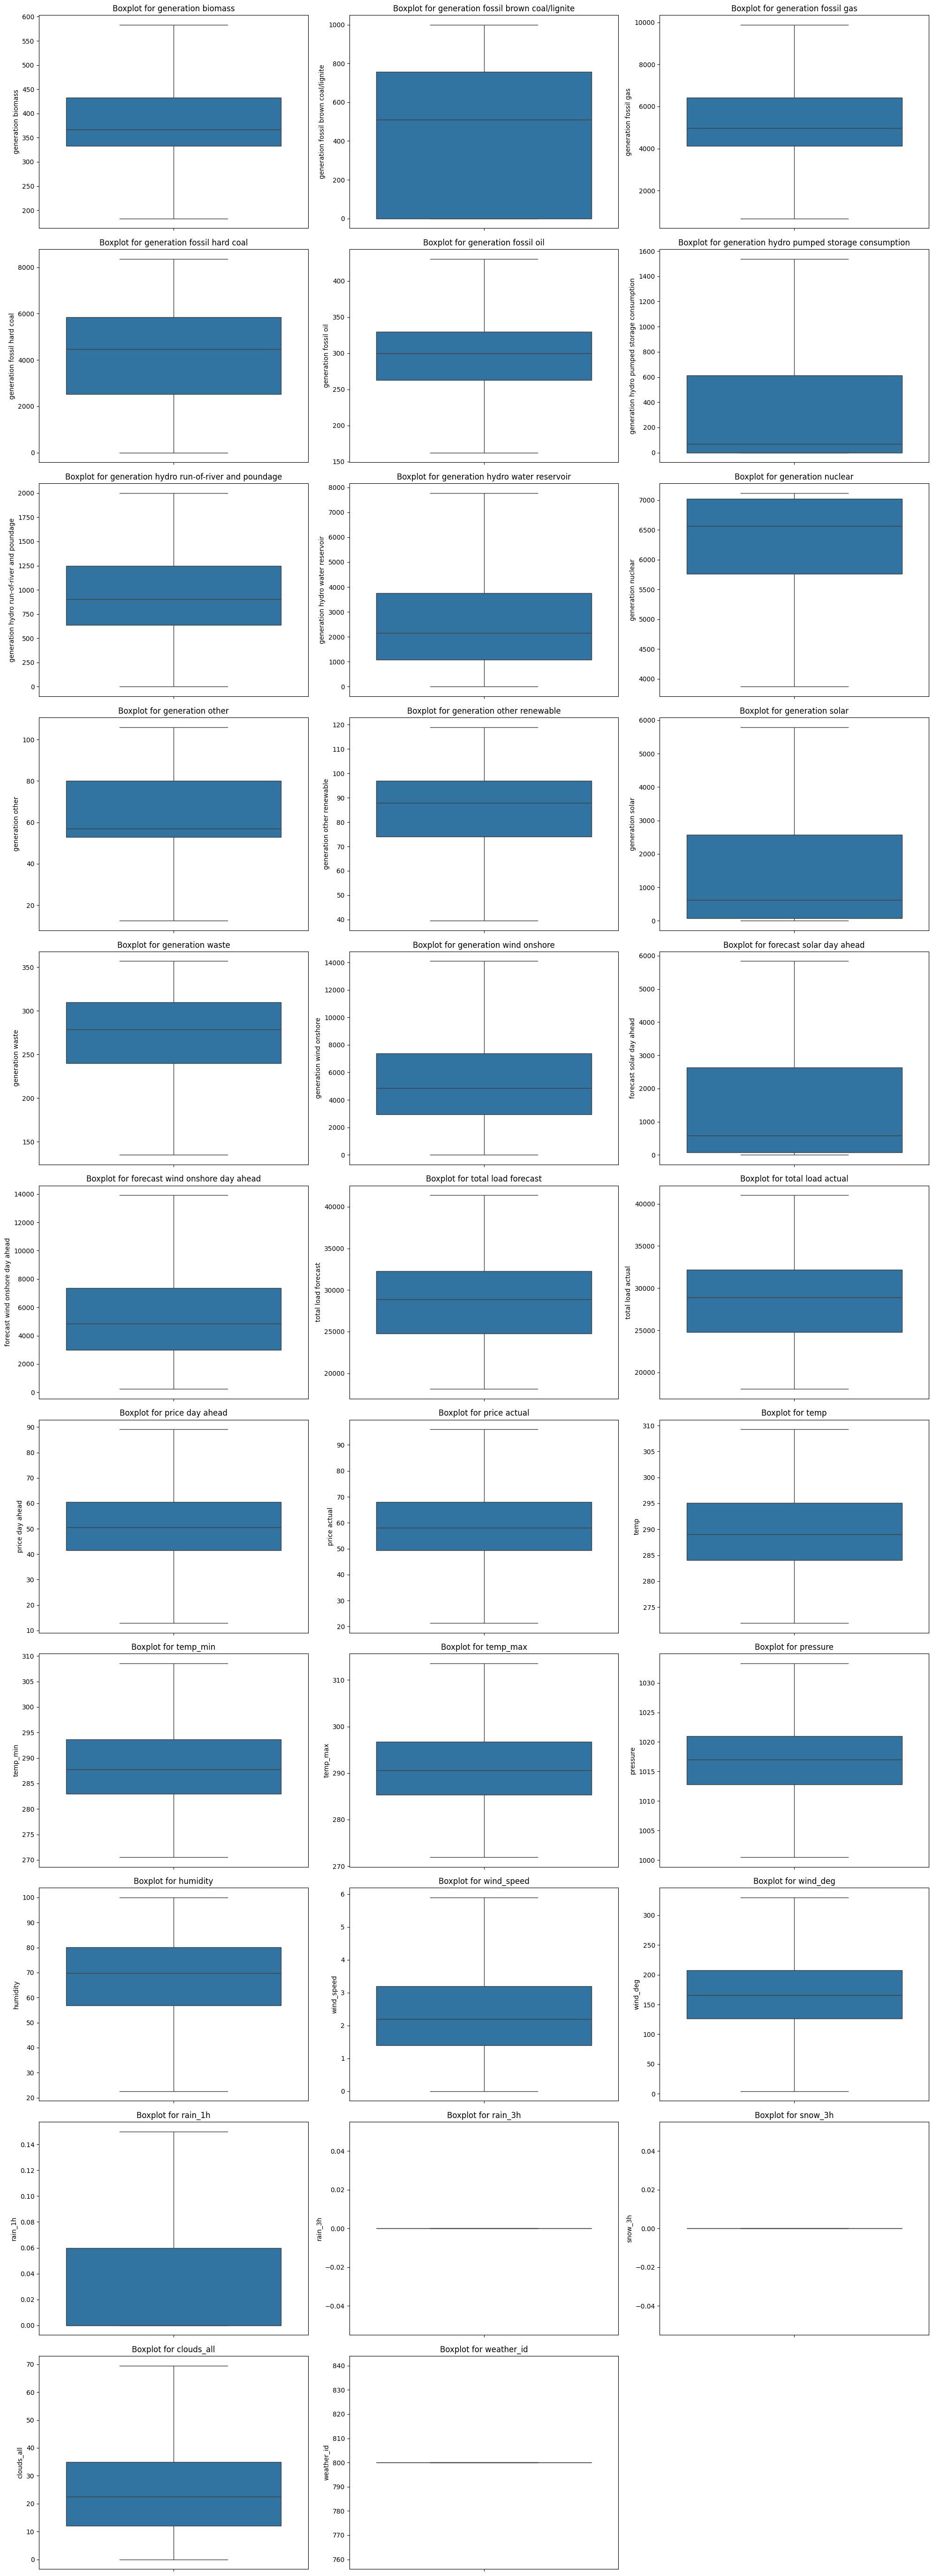

In [110]:

# Create subplots for boxplots
def plot_boxplots(df, columns):
    n_cols = 3
    n_rows = int(np.ceil(len(columns) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.boxplot(df[col], ax=axes[i])
        axes[i].set_title(f'Boxplot for {col}')

    # Remove any empty subplots
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Plot boxplots for numerical columns after capping outliers
plot_boxplots(merged_df, numerical_cols)

Feature Engineering

In [111]:
def identify_outliers_df(df):
    outliers = pd.DataFrame()
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = (df[column] < lower_bound) | (df[column] > upper_bound)
    return outliers

In [112]:
# Identify outliers in the merged DataFrame
outliers_df = identify_outliers_df(merged_df)

In [113]:
outliers_df

generation biomass  generation fossil brown coal/lignite  \
0                   False                                 False   
1                   False                                 False   
2                   False                                 False   
3                   False                                 False   
4                   False                                 False   
...                   ...                                   ...   
35059               False                                 False   
35060               False                                 False   
35061               False                                 False   
35062               False                                 False   
35063               False                                 False   

       generation fossil gas  generation fossil hard coal  \
0                      False                        False   
1                      False                        False   
2                      False                        False   
3                      False                        False   
4                      False                        False   
...                      ...                          ...   
35059                  False                        False   
35060                  False                        False   
35061                  False                        False   
35062                  False                        False   
35063                  False                        False   

       generation fossil oil  generation hydro pumped storage consumption  \
0                      False                                        False   
1                      False                                        False   
2                      False                                        False   
3                      False                                        False   
4                      False                                        False   
...                      ...                                          ...   
35059                  False                                        False   
35060                  False                                        False   
35061                  False                                        False   
35062                  False                                        False   
35063                  False                                        False   

       generation hydro run-of-river and poundage  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                           False   
...                                           ...   
35059                                       False   
35060                                       False   
35061                                       False   
35062                                       False   
35063                                       False   

       generation hydro water reservoir  generation nuclear  generation other  \
0                                 False               False             False   
1                                 False               False             False   
2                                 False               False             False   
3                                 False               False             False   
4                                 False               False             False   
...                                 ...                 ...               ...   
35059                             False               False             False   
35060                             False               False             False   
35061                             False               False             False   
35062                             False               False             False   
35063           

****

**Treat outliers by capping them at the lower and upper bounds for the entire DataFrame**

In [114]:
def treat_outliers_df(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

In [115]:
# Treat outliers in the merged DataFrame
treat_outliers_df(merged_df)

In [116]:
outliers_df = identify_outliers_df(merged_df)

In [117]:
outliers_df

generation biomass  generation fossil brown coal/lignite  \
0                   False                                 False   
1                   False                                 False   
2                   False                                 False   
3                   False                                 False   
4                   False                                 False   
...                   ...                                   ...   
35059               False                                 False   
35060               False                                 False   
35061               False                                 False   
35062               False                                 False   
35063               False                                 False   

       generation fossil gas  generation fossil hard coal  \
0                      False                        False   
1                      False                        False   
2                      False                        False   
3                      False                        False   
4                      False                        False   
...                      ...                          ...   
35059                  False                        False   
35060                  False                        False   
35061                  False                        False   
35062                  False                        False   
35063                  False                        False   

       generation fossil oil  generation hydro pumped storage consumption  \
0                      False                                        False   
1                      False                                        False   
2                      False                                        False   
3                      False                                        False   
4                      False                                        False   
...                      ...                                          ...   
35059                  False                                        False   
35060                  False                                        False   
35061                  False                                        False   
35062                  False                                        False   
35063                  False                                        False   

       generation hydro run-of-river and poundage  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                           False   
...                                           ...   
35059                                       False   
35060                                       False   
35061                                       False   
35062                                       False   
35063                                       False   

       generation hydro water reservoir  generation nuclear  generation other  \
0                                 False               False             False   
1                                 False               False             False   
2                                 False               False             False   
3                                 False               False             False   
4                                 False               False             False   
...                                 ...                 ...               ...   
35059                             False               False             False   
35060                             False               False             False   
35061                             False               False             False   
35062                             False               False             False   
35063           

**Extract new features from the datetime column**

In [118]:
merged_df['time'] = pd.to_datetime(merged_df['time'], utc=True)

merged_df['day'] = merged_df['time'].dt.day
merged_df['month'] = merged_df['time'].dt.month
merged_df['day_of_week'] = merged_df['time'].dt.dayofweek

**Create binary columns for each month from January to December**

In [119]:
# merged_df['month'] == month creates a boolean series
# where the value is True if the month column matches the current month in the loop, and False otherwise.
# .astype(int) converts the boolean series to integers, resulting in 1 for True and 0 for False.

for month in range(1, 13):
    merged_df[f'month_{month}'] = (merged_df['month'] == month).astype(int)


**Drop the original month column as it's no longer needed**

In [120]:
merged_df.drop(columns=['month'], inplace=True)

**Rename the Months**

In [121]:
merged_df.rename(columns={'month_1': 'January',
                           'month_2': 'February',
                           'month_3': 'March',
                           'month_4': 'April',
                           'month_5': 'May',
                           'month_6': 'June',
                           'month_7': 'July',
                           'month_8': 'August',
                           'month_9': 'September',
                           'month_10': 'October',
                           'month_11': 'November',
                           'month_12': 'December'}, inplace=True)


**Create binary columns for each day of the week**


In [122]:
for day in range(7):
    merged_df[f'day_of_week_{day}'] = (merged_df['day_of_week'] == day).astype(int)


**Drop the original day_of_week column as it's no longer needed**

In [123]:
merged_df.drop(columns=['day_of_week'], inplace=True)

**Rename of each day of week**

In [124]:
merged_df.rename(columns={'day_of_week_0': 'Monday',
                          'day_of_week_1': 'Tuesday',
                          'day_of_week_2': 'Wednesday',
                          'day_of_week_3': 'Thursday',
                          'day_of_week_4': 'Friday',
                          'day_of_week_5': 'Saturday',
                          'day_of_week_6': 'Sunday'}, inplace=True)




```
# This is formatted as code
```

**Peak and Non-Peak Hours**

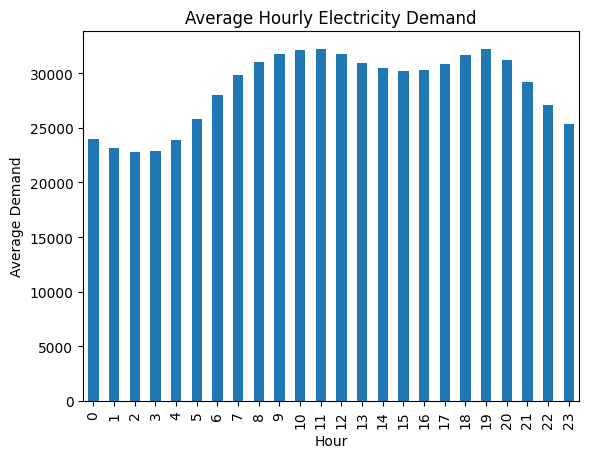

In [125]:
# Extract hour and plot average demand per hour
merged_df['hour'] = merged_df['time'].dt.hour

hourly_demand = merged_df.groupby('hour')['total load actual'].mean()

hourly_demand.plot(kind='bar')
plt.title('Average Hourly Electricity Demand')
plt.xlabel('Hour')
plt.ylabel('Average Demand')
plt.show()


**Creating Binary Columns for Peak and Non-Peak Hours**

In [126]:
# Peak hours are from 7 AM to 10 PM (7 to 20) and non-peak hours are the remaining hours.
# Define peak and non-peak hours
merged_df['peak_hour'] = merged_df['hour'].apply(lambda x: 1 if 7 <= x <= 20 else 0)
merged_df['non_peak_hour'] = merged_df['hour'].apply(lambda x: 1 if x < 7 or x > 20 else 0)

**Save New Data Frame**

In [127]:
merged_df['time'] = merged_df['time'].astype(str)

output_path = 'merged_data.xlsx'
merged_df.to_excel(output_path, index=False)

In [128]:
#merged_df = pd.read_excel('merged_data.xlsx')

In [129]:
merged_df['time'] = pd.to_datetime(merged_df['time'], utc=True)

In [130]:
merged_df.head()

time  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   
3                                 254.0                 4314.0   
4                                 187.0                 4130.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.5   
1                       4755.0                  162.5   
2                       4581.0                  162.5   
3                       4131.0                  162.5   
4                       3840.0                  162.5   

   generation hydro pumped storage consumption  \
0                                        863.0   
1                                        920.0   
2                                       1164.0   
3                                       1503.0   
4                                       1537.5   

   generation hydro run-of-river and poundage  \
0                                      1051.0   
1                                      1009.0   
2                                       973.0   
3                                       949.0   
4                                       953.0   

   generation hydro water reservoir  generation nuclear  ...  Monday  Tuesday  \
0                            1899.0              7096.0  ...       0        0   
1                            1658.0              7096.0  ...       0        0   
2                            1371.0              7099.0  ...       0        0   
3                             779.0              7098.0  ...       0        0   
4                             720.0              7097.0  ...       0        0   

   Wednesday  Thursday  Friday  Saturday  Sunday  hour  peak_hour  \
0          1         0       0         0       0    23          0   
1          0         1       0         0       0     0          0   
2          0         1       0         0       0     1          0   
3          0         1       0         0       0     2          0   
4          0         1       0         0       0     3          0   

   non_peak_hour  
0              1  
1              1  
2              1  
3              1  
4              1  

[5 rows x 59 columns]

In [131]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 59 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35064 non-null  float64            
 2   generation fossil brown coal/lignite         35064 non-null  float64            
 3   generation fossil gas                        35064 non-null  float64            
 4   generation fossil hard coal                  35064 non-null  float64            
 5   generation fossil oil                        35064 non-null  float64            
 6   generation hydro pumped storage consumption  35064 non-null  float64            
 7   generation hydro run-of-river and poundage   35064 non-null  float64            
 8   generation hydro water res

#visulization

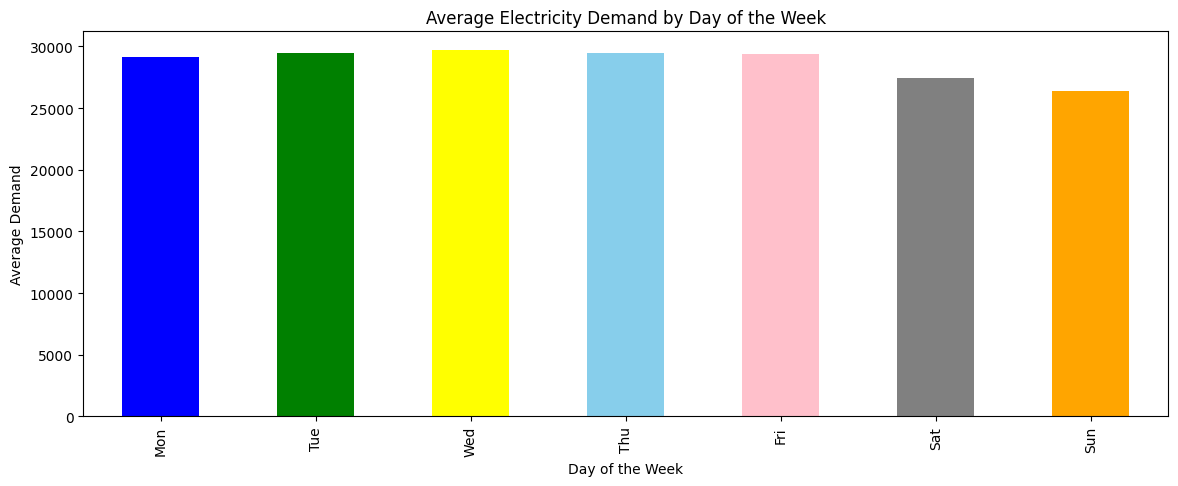

In [132]:
# Group by day of week and calculate the mean demand
dayofweek_demand = merged_df.groupby(merged_df['time'].dt.dayofweek)['total load actual'].mean()

# Define a list of colors for each day of week
colors = ['blue', 'green', 'yellow', 'skyblue', 'pink', 'gray', 'orange']

plt.figure(figsize=(14, 5))
dayofweek_demand.plot(kind='bar', color=colors)
plt.title('Average Electricity Demand by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Demand')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

**Average electricity demand by day of the week**

**Bar Chart Comparing Electricity Demand by Month**

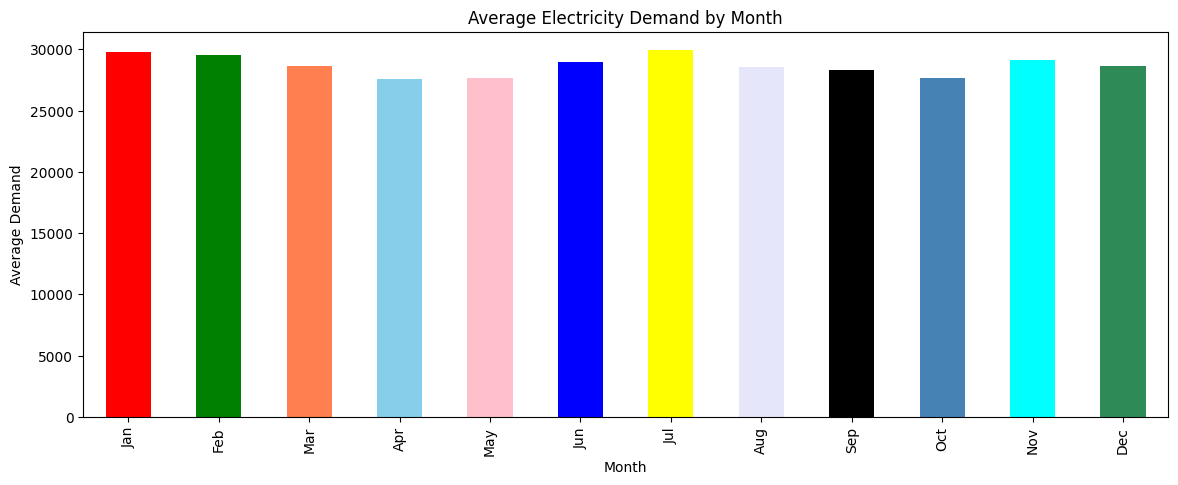

In [133]:
# Group by month and calculate the mean demand
monthly_demand = merged_df.groupby(merged_df['time'].dt.month)['total load actual'].mean()

# Define a list of colors for each month
colors = ['red', 'green', 'coral', 'skyblue', 'pink', 'blue', 'yellow', 'lavender', 'black', 'steelblue', 'cyan', 'seagreen']

plt.figure(figsize=(14, 5))
monthly_demand.plot(kind='bar', color=colors)
plt.title('Average Electricity Demand by Month')
plt.xlabel('Month')
plt.ylabel('Average Demand')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()



```
# This is formatted as code
```

**Average electricity demand by weather condition**

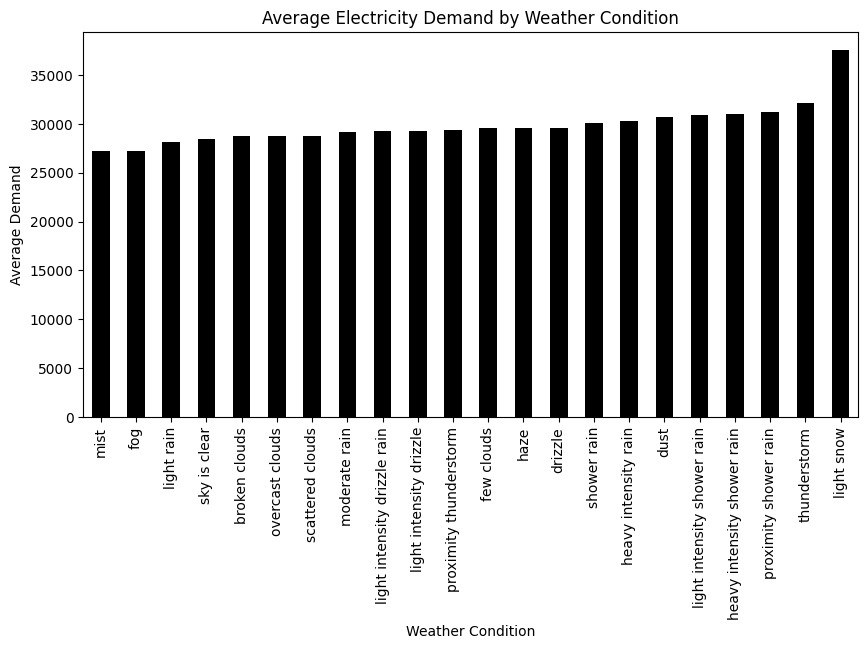

In [134]:
plt.figure(figsize=(10, 5))
avg_demand_by_weather = merged_df.groupby('weather_description')['total load actual'].mean().sort_values()
avg_demand_by_weather.plot(kind='bar', color='black')
plt.title('Average Electricity Demand by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Demand')
plt.xticks(rotation=90)
plt.show()

[link text](https://)**Average Electricity Demand hourly**

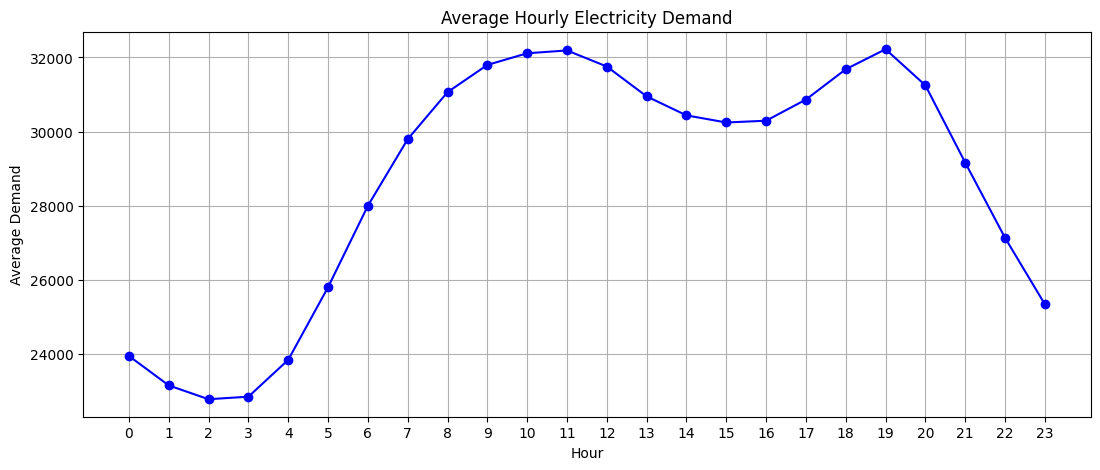

In [135]:
hourly_demand = merged_df.groupby('hour')['total load actual'].mean()

plt.figure(figsize=(13, 5))
plt.plot(range(0,24),hourly_demand,marker='o',linestyle='-',color='blue')
plt.title('Average Hourly Electricity Demand')
plt.xlabel('Hour')
plt.ylabel('Average Demand')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

**Line Plot of Electricity Demand Over Time**

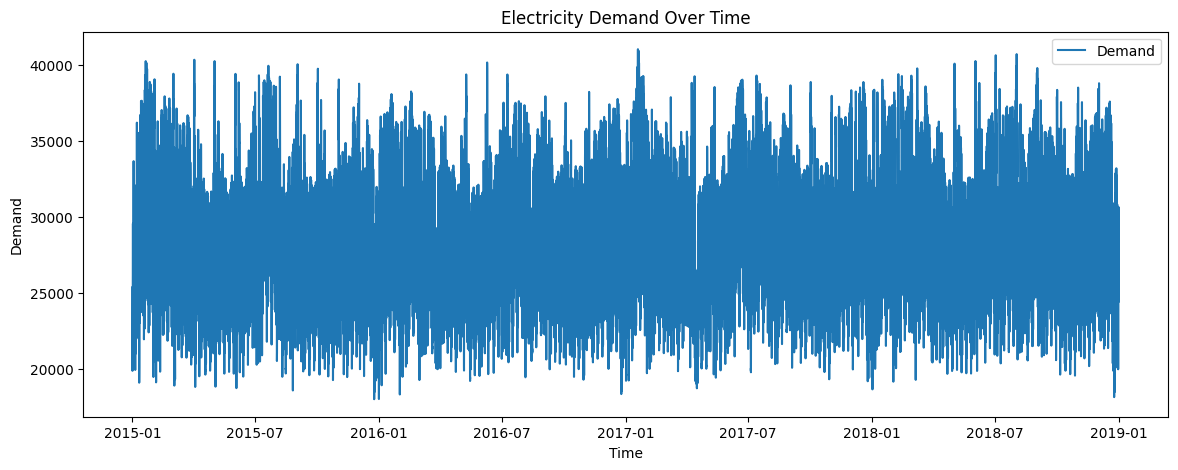

In [136]:
plt.figure(figsize=(14, 5))
plt.plot(merged_df['time'], merged_df['total load actual'], label='Demand')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Electricity Demand Over Time')
plt.legend()
plt.show()

#Average electricity demand during non Peak Hour

<ipython-input-137-37336a1e80d5>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=peak_demand, x='peak_hour', y='total load actual', palette=colors)


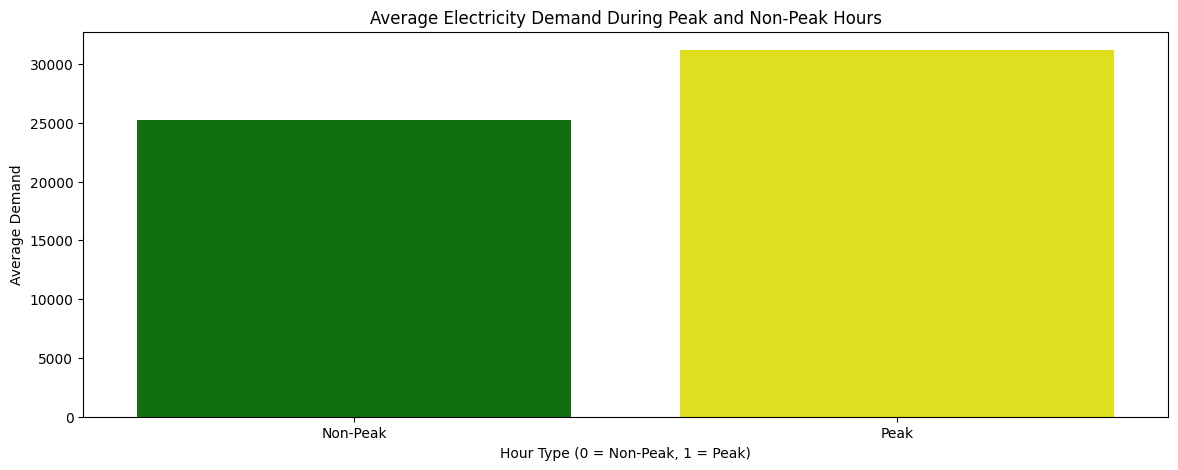

In [137]:
# Group by peak and non-peak hours and calculate the mean demand
peak_demand = merged_df.groupby('peak_hour')['total load actual'].mean().reset_index()

# Define colors for the bars
colors = ['green' if peak == 0 else 'yellow' for peak in peak_demand['peak_hour']]

# Plotting the bar chart
plt.figure(figsize=(14, 5))
sns.barplot(data=peak_demand, x='peak_hour', y='total load actual', palette=colors)
plt.title('Average Electricity Demand During Peak and Non-Peak Hours')
plt.xlabel('Hour Type (0 = Non-Peak, 1 = Peak)')
plt.ylabel('Average Demand')
plt.xticks(ticks=[0, 1], labels=['Non-Peak', 'Peak'])
plt.show()

**Correlation matrix**

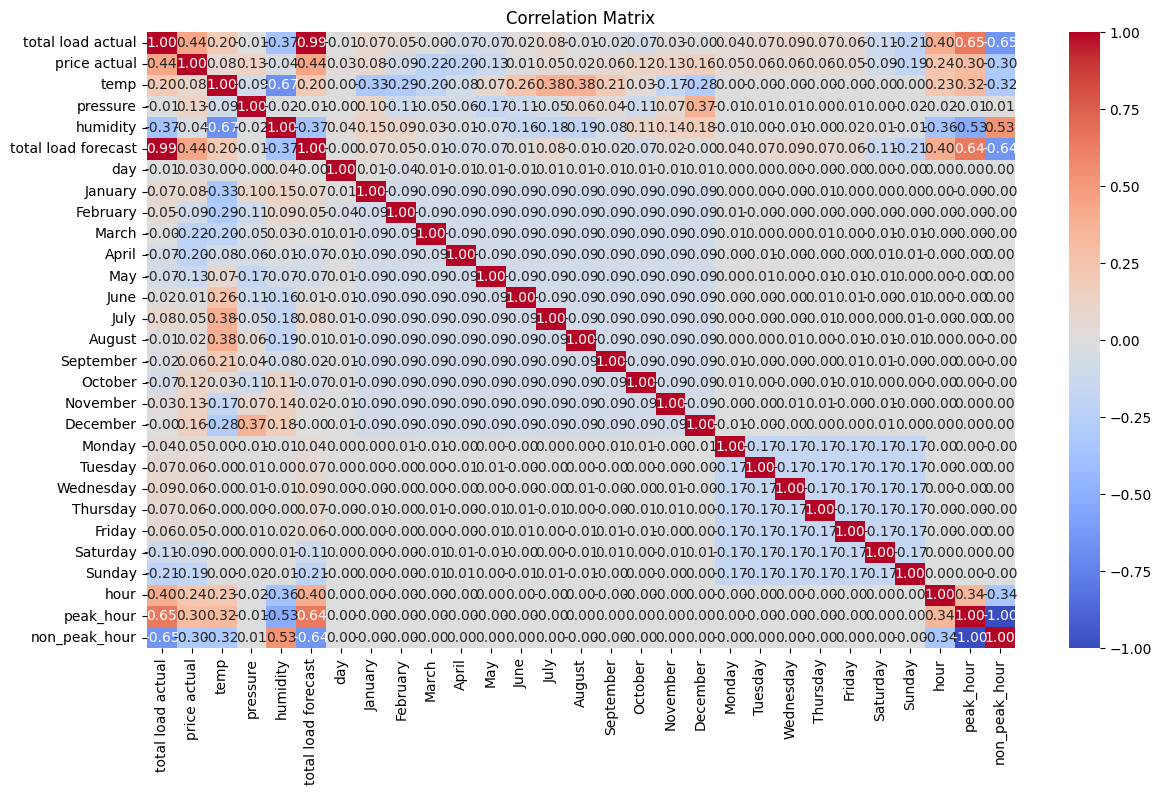

In [138]:
corr_matrix = merged_df[['total load actual','price actual','temp','pressure','humidity','total load forecast','day','January','February',
                         'March','April','May','June','July','August','September','October','November','December','Monday','Tuesday',
                         'Wednesday','Thursday','Friday','Saturday','Sunday','hour','peak_hour','non_peak_hour']].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True,fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

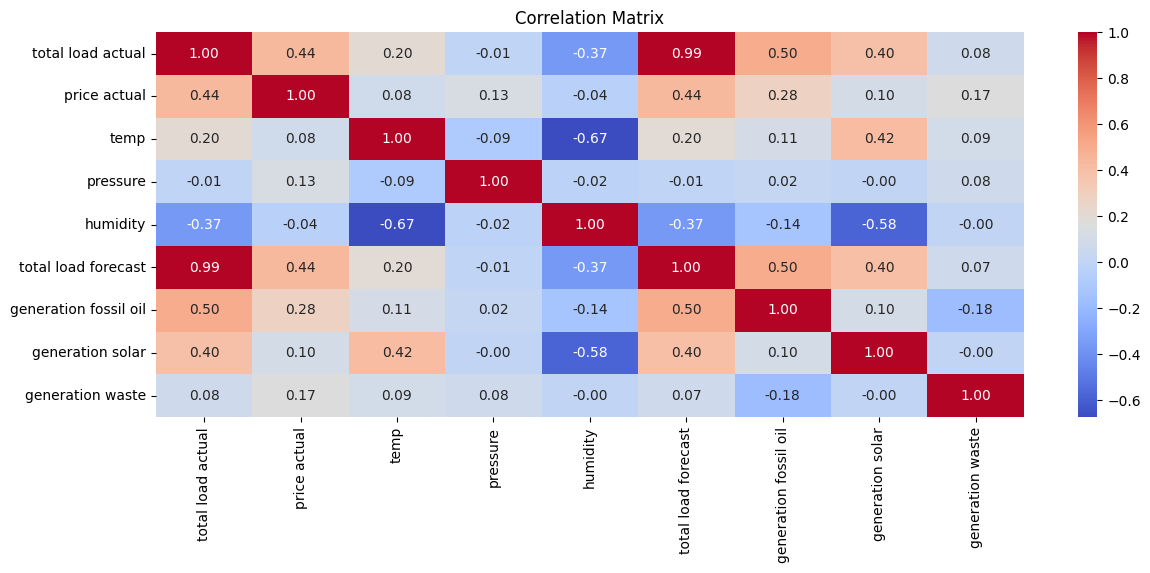

In [139]:
corr_matrix = merged_df[['total load actual','price actual','temp','pressure','humidity','total load forecast',
                         'generation fossil oil','generation solar','generation waste']].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(14, 5))
sns.heatmap(corr_matrix, annot=True,fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Encode categorical variables**

In [140]:
label_encoder = {}
for column in merged_df.select_dtypes(include=['object']).columns:
    label_encoder[column] = LabelEncoder()
    # Check if the column contains mixed types and convert to string if necessary
    if merged_df[column].apply(type).nunique() > 1:
        merged_df[column] = merged_df[column].astype(str)
    merged_df[column] = label_encoder[column].fit_transform(merged_df[column]) # Now apply label encoding

#**Feature selection using RFE**

In [141]:
features_demand = merged_df[['generation biomass', 'generation fossil brown coal/lignite','generation fossil gas', 'generation fossil hard coal',
                   'generation hydro run-of-river and poundage', 'generation hydro water reservoir','generation other renewable',
                   'generation fossil oil', 'generation hydro pumped storage consumption','generation nuclear', 'generation other',
                   'generation solar', 'generation waste', 'generation wind onshore','forecast solar day ahead',
                   'forecast wind onshore day ahead', 'price day ahead', 'temp', 'temp_min',
                   'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg','rain_1h', 'snow_3h', 'clouds_all',
                   'day', 'January', 'February', 'March', 'April', 'May','June', 'July', 'August', 'September', 'October', 'November',
                   'December', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                   'Saturday', 'Sunday', 'hour', 'peak_hour', 'non_peak_hour']]
features_price = merged_df[['generation biomass', 'generation fossil brown coal/lignite','generation fossil gas', 'generation fossil hard coal',
                   'generation hydro run-of-river and poundage', 'generation hydro water reservoir','generation other renewable',
                   'generation fossil oil', 'generation hydro pumped storage consumption','generation nuclear', 'generation other',
                   'generation solar', 'generation waste', 'generation wind onshore','forecast solar day ahead',
                   'forecast wind onshore day ahead','total load forecast', 'temp', 'temp_min',
                   'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg','rain_1h', 'snow_3h', 'clouds_all',
                   'day', 'January', 'February', 'March', 'April', 'May','June', 'July', 'August', 'September', 'October', 'November',
                   'December', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                   'Saturday', 'Sunday', 'hour', 'peak_hour', 'non_peak_hour']]
target_demand = merged_df['total load actual']
target_price = merged_df['price actual']

X_train_demand, X_test_demand, y_train_demand, y_test_demand = train_test_split(features_demand, target_demand, test_size=0.2, random_state=42)
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(features_price, target_price, test_size=0.2, random_state=42)

**Feature selection using RFE for demand prediction**


In [142]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Feature selection using RFE for demand prediction with a specific number of features
n_features_to_select = 30
rfe_demand = RFE(estimator=lr_model, n_features_to_select=n_features_to_select)
rfe_demand.fit(X_train_demand, y_train_demand)

# Get selected features for demand prediction
selected_features_demand = X_train_demand.columns[rfe_demand.support_]
print("Selected features for demand prediction:", selected_features_demand)

Selected features for demand prediction: Index(['generation fossil oil', 'price day ahead', 'temp', 'temp_min',
       'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'January',
       'February', 'March', 'April', 'May', 'June', 'July', 'August',
       'September', 'October', 'December', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour', 'peak_hour',
       'non_peak_hour'],
      dtype='object')


**Feature selection using RFE for price prediction**

In [143]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Feature selection using RFE for price prediction with a specific number of features
n_features_to_select = 30
rfe_price = RFE(estimator=lr_model, n_features_to_select=n_features_to_select)
rfe_price.fit(X_train_price, y_train_price)

# Get selected features for demand prediction
selected_features_price = X_train_price.columns[rfe_price.support_]
print("Selected features for price prediction:", selected_features_price)

Selected features for price prediction: Index(['generation other renewable', 'temp', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'rain_1h', 'January', 'February',
       'March', 'April', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour', 'peak_hour',
       'non_peak_hour'],
      dtype='object')


**Define the features and target variable**

features_demand = merged_df[['generation fossil oil', 'price day ahead', 'temp', 'temp_min',
       'temp_max', 'pressure', 'wind_speed', 'rain_1h', 'January', 'February',
       'March', 'April', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour', 'peak_hour',
       'non_peak_hour']]

features_price = merged_df[['generation other renewable', 'temp', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'rain_1h', 'January', 'February',
       'March', 'April', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour', 'peak_hour',
       'non_peak_hour']]

target_demand = merged_df['total load actual']
target_price = merged_df['price actual']

#**Traning Model**

**Split the data into training and testing sets**

In [144]:
X_train_demand, X_test_demand, y_train_demand, y_test_demand = train_test_split(features_demand, target_demand, test_size=0.2, random_state=42)
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(features_price, target_price, test_size=0.2, random_state=42)

# **Linear Regression**

**Train a Linear Regression model to predict price**


In [145]:
lr_model = LinearRegression()
lr_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_price)

# Calculate MAPE
mape_lr_p = mean_absolute_percentage_error(y_test_price, y_pred_lr)
print(f'Linear Regression MAPE for price: {mape_lr_p * 100:.2f}%')
# Calculate MAE
mae_lr_p = mean_absolute_error(y_test_price, y_pred_lr)
print(f'Linear Regression MAE for price: {mae_lr_p:.2f}')
# Calculate RMSE
rmse_lr_p = np.sqrt(mean_squared_error(y_test_price, y_pred_lr))
print(f'Linear Regression RMSE for price: {rmse_lr_p:.2f}')
# Calculate R^2
r2_lr_p = r2_score(y_test_price, y_pred_lr)
print(f'Linear Regression R2 for price: {r2_lr_p:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Use the correct variable name r2_lr_p
adjusted_r2_lr_p = adjusted_r2_score(r2_lr_p, X_train_price.shape[0], X_train_price.shape[1])
print(f'Linear Regression Adjusted R2 for price: {adjusted_r2_lr_p:.2f}')

Linear Regression MAPE for price: 14.45%
Linear Regression MAE for price: 7.36
Linear Regression RMSE for price: 9.41
Linear Regression R2 for price: 0.55
Linear Regression Adjusted R2 for price: 0.55


**Actual vs Predicted Electricity Price (Linear Regression)**


Actual vs Predicted Electricity Price (Linear Regression)


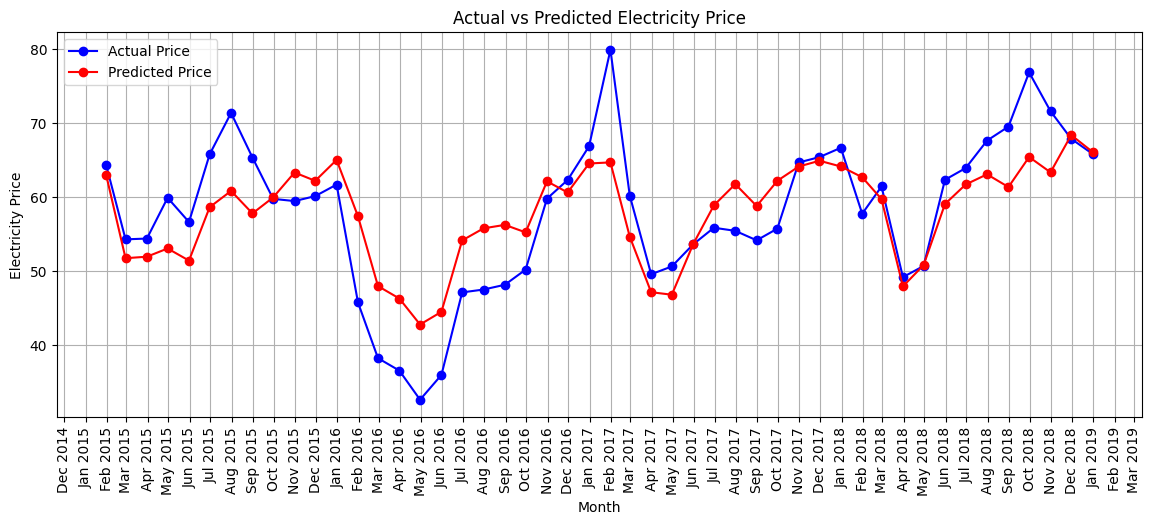

In [146]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Price (Linear Regression)", ['bold']))

test_indices = X_test_price.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_lr})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


**Train a Linear Regression model to predict demand**


In [148]:
lr_model = LinearRegression()
lr_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_demand)

# Calculate MAPE
mape_lr = mean_absolute_percentage_error(y_test_demand, y_pred_lr)
print(f'Linear Regression MAPE for demand: {mape_lr * 100:.2f}%')
# Calculate MAE
mae_lr = mean_absolute_error(y_test_demand, y_pred_lr)
print(f'Linear Regression MAE for demand: {mae_lr:.2f}')
# Calculate RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test_demand, y_pred_lr))
print(f'Linear Regression RMSE for demand: {rmse_lr:.2f}')
# Calculate R^2
r2_lr = r2_score(y_test_demand, y_pred_lr)
print(f'Linear Regression R2 for demand: {r2_lr:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_lr = adjusted_r2_score(r2_lr, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'Linear Regression Adjusted R2 for demand: {adjusted_r2_lr:.2f}')

Linear Regression MAPE for demand: 3.51%
Linear Regression MAE for demand: 988.43
Linear Regression RMSE for demand: 1270.09
Linear Regression R2 for demand: 0.92
Linear Regression Adjusted R2 for demand: 0.92


**Actual vs Predicted Electricity Demand (Linear Regression)**


Actual vs Predicted Electricity Demand (Linear Regression)


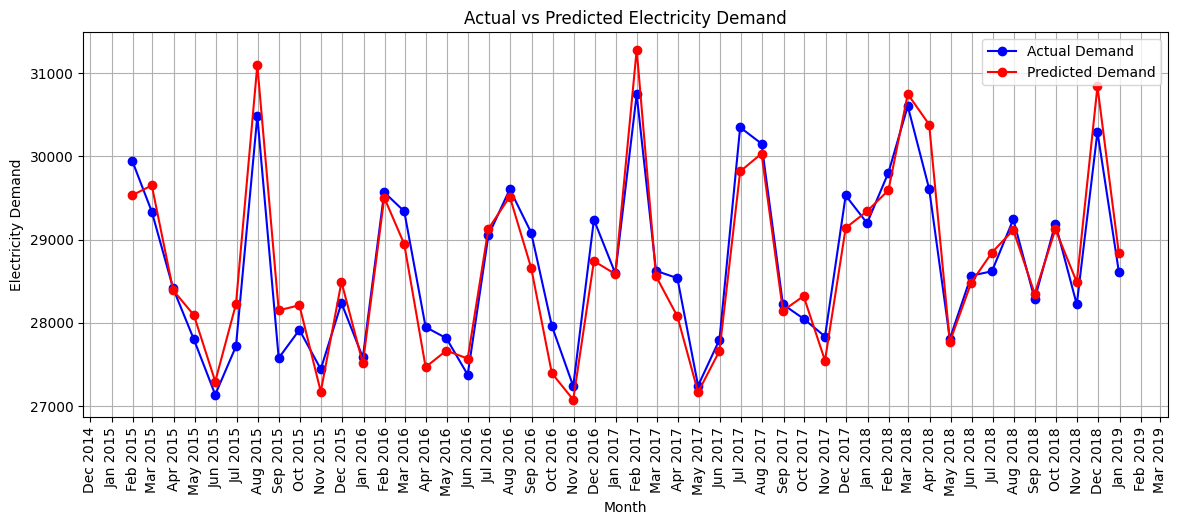

In [149]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Demand (Linear Regression)", ['bold']))

test_indices = X_test_demand.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_lr})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Demand', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Demand', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


# **Decision Tree**

**Train a Decision Tree model to predict demand**


In [151]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test_demand)

# Calculate MAPE
mape_dt = mean_absolute_percentage_error(y_test_demand, y_pred_dt)
print(f'Decision Tree MAPE for demand: {mape_dt * 100:.2f}%')
# Calculate MAE
mae_dt = mean_absolute_error(y_test_demand, y_pred_dt)
print(f'Decision Tree MAE for demand: {mae_dt:.2f}')
# Calculate RMSE
rmse_dt = np.sqrt(mean_squared_error(y_test_demand, y_pred_dt))
print(f'Decision Tree RMSE for demand: {rmse_dt:.2f}')
# Calculate R^2
r2_dt = r2_score(y_test_demand, y_pred_dt)
print(f'Decision Tree R2 for demand: {r2_dt:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_dt = adjusted_r2_score(r2_dt, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'Decision Tree Adjusted R2 for demand: {adjusted_r2_dt:.2f}')

Decision Tree MAPE for demand: 3.84%
Decision Tree MAE for demand: 1079.00
Decision Tree RMSE for demand: 1546.34
Decision Tree R2 for demand: 0.89
Decision Tree Adjusted R2 for demand: 0.89


**Actual vs Predicted Electricity Demand (Decision Tree)**


Actual vs Predicted Electricity Demand (Decision Tree)


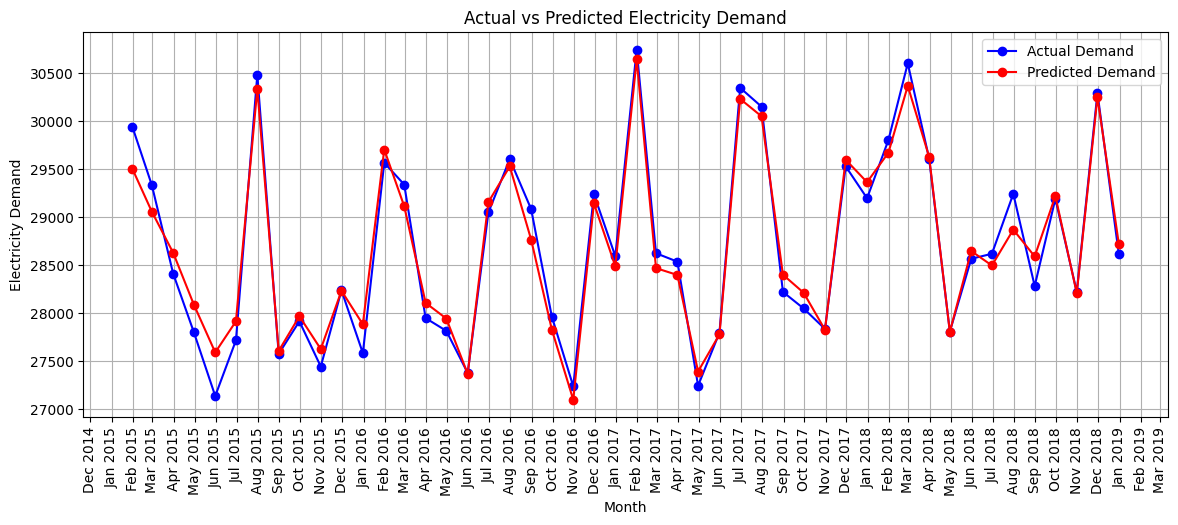

In [152]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Demand (Decision Tree)", ['bold']))

test_indices = X_test_demand.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_dt})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Demand', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Demand', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()



**Train a Decision Tree model to predict price**


In [154]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test_price)

# Calculate MAPE
mape_dt_p = mean_absolute_percentage_error(y_test_price, y_pred_dt)
print(f'Decision Tree MAPE for price: {mape_dt_p * 100:.2f}%')
# Calculate MAE
mae_dt_p = mean_absolute_error(y_test_price, y_pred_dt)
print(f'Decision Tree MAE for price: {mae_dt_p:.2f}')
# Calculate RMSE
rmse_dt_p = np.sqrt(mean_squared_error(y_test_price, y_pred_dt))
print(f'Decision Tree RMSE for price: {rmse_dt_p:.2f}')
# Calculate R^2
r2_dt_p = r2_score(y_test_price, y_pred_dt)
print(f'Decision Tree R2 for price: {r2_dt_p:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_dt_p = adjusted_r2_score(r2_dt, X_train_price.shape[0], X_train_price.shape[1])
print(f'Decision Tree Adjusted R2 for price: {adjusted_r2_dt_p:.2f}')

Decision Tree MAPE for price: 8.07%
Decision Tree MAE for price: 4.24
Decision Tree RMSE for price: 6.90
Decision Tree R2 for price: 0.76
Decision Tree Adjusted R2 for price: 0.89


**Actual vs Predicted Electricity Price (Decision Tree)**

Actual vs Predicted Electricity Price (Decision Tree)


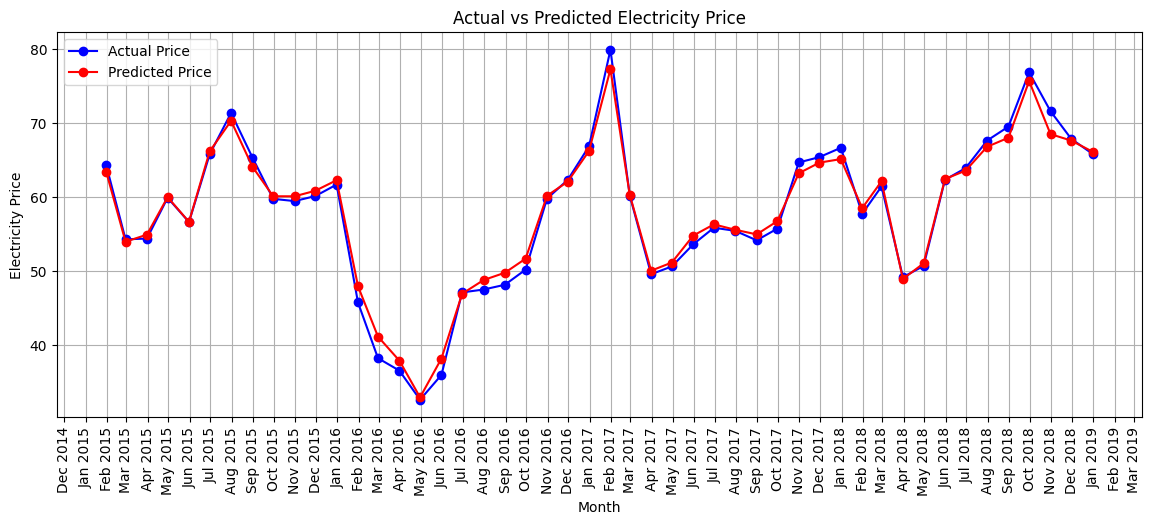

In [155]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Price (Decision Tree)", ['bold']))

test_indices = X_test_price.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_dt})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


# **Random Forest**

**Train a Random Forest model to predict demand**

In [157]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_demand)

# Calculate MAPE
mape_rf = mean_absolute_percentage_error(y_test_demand, y_pred_rf)
print(f'Random Forest MAPE for demand: {mape_rf * 100:.2f}%')
# Calculate MAE
mae_rf = mean_absolute_error(y_test_demand, y_pred_rf)
print(f'Random Forest MAE for demand: {mae_rf:.2f}')
# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test_demand, y_pred_rf))
print(f'Random Forest RMSE for demand: {rmse_rf:.2f}')
# Calculate R^2
r2_rf = r2_score(y_test_demand, y_pred_rf)
print(f'Random Forest R2 for demand: {r2_rf:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_rf = adjusted_r2_score(r2_rf, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'Random Forest Adjusted R2 for demand: {adjusted_r2_rf:.2f}')

Random Forest MAPE for demand: 2.47%
Random Forest MAE for demand: 689.00
Random Forest RMSE for demand: 939.23
Random Forest R2 for demand: 0.96
Random Forest Adjusted R2 for demand: 0.96


**Actual vs Predicted Electricity Demand (Random Forest)**

Actual vs Predicted Electricity Demand (Random Forest)


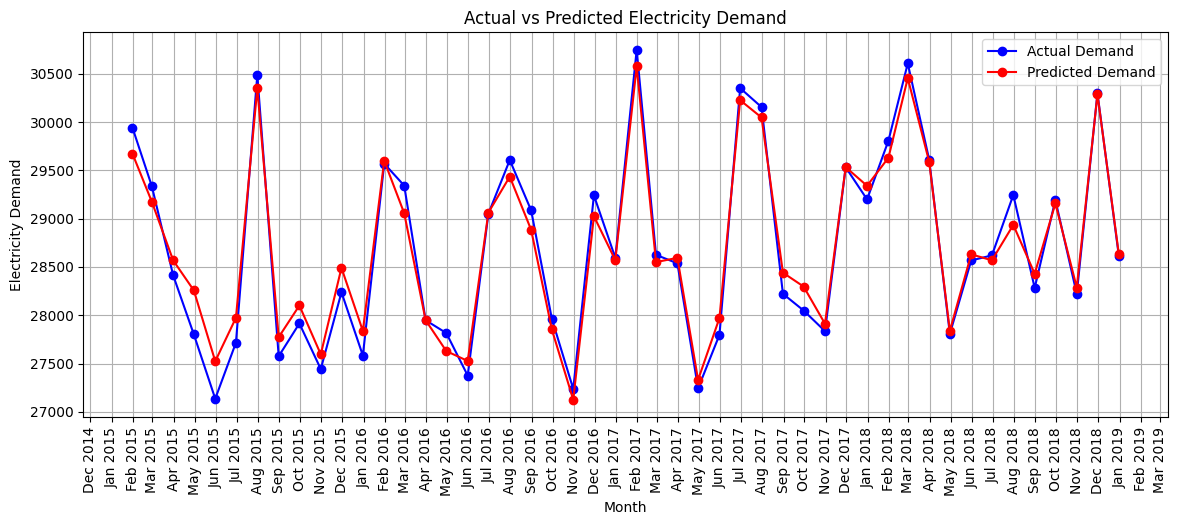

In [158]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Demand (Random Forest)", ['bold']))

test_indices = X_test_demand.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_rf})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Demand', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Demand', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


**Train a Random Forest model to predict price**

In [160]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_price)

# Calculate MAPE
mape_rf_p = mean_absolute_percentage_error(y_test_price, y_pred_rf)
print(f'Random Forest MAPE for price: {mape_rf_p * 100:.2f}%')
# Calculate MAE
mae_rf_p = mean_absolute_error(y_test_price, y_pred_rf)
print(f'Random Forest MAE for price: {mae_rf_p:.2f}')
# Calculate RMSE
rmse_rf_p = np.sqrt(mean_squared_error(y_test_price, y_pred_rf))
print(f'Random Forest RMSE for price: {rmse_rf_p:.2f}')
# Calculate R^2
r2_rf_p = r2_score(y_test_price, y_pred_rf)
print(f'Random Forest R2 for price: {r2_rf_p:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_rf_p = adjusted_r2_score(r2_rf, X_train_price.shape[0], X_train_price.shape[1])
print(f'Random Forest Adjusted R2 for price: {adjusted_r2_rf_p:.2f}')

Random Forest MAPE for price: 5.67%
Random Forest MAE for price: 2.90
Random Forest RMSE for price: 4.18
Random Forest R2 for price: 0.91
Random Forest Adjusted R2 for price: 0.96


**Actual vs Predicted Electricity Price (Random Forest)**

Actual vs Predicted Electricity Price (Random Forest)


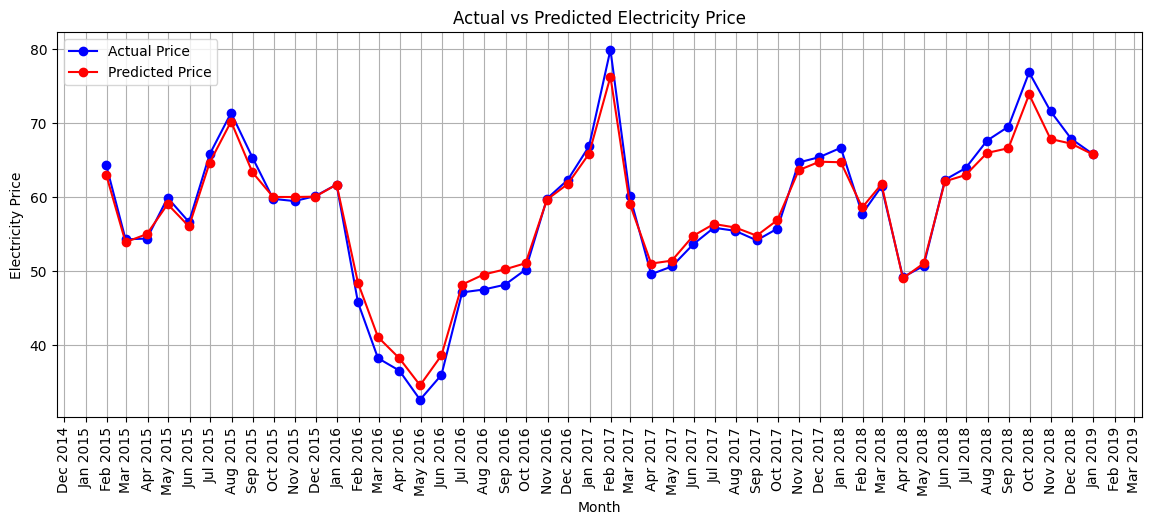

In [161]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Price (Random Forest)", ['bold']))

test_indices = X_test_price.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_rf})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


# **Random Forest with Parameter Tuning**

**Train a Random Forest(tuning) model to predict demand**


In [163]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform Grid Search with cross-validation
with parallel_backend('threading'):
    grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                                  cv=5, n_jobs=1, scoring='neg_mean_squared_error', verbose=2)

# Fit the model
grid_search_rf.fit(X_train_demand, y_train_demand.ravel())

# Get the best parameters and the best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
print("Best parameters for Random Forest:", best_params_rf)
print("Best score for Random Forest:", best_score_rf)

# Use the best estimator to make predictions
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_tun = best_rf_model.predict(X_test_demand)

# Calculate MAPE
mape_rf_tun = mean_absolute_percentage_error(y_test_demand, y_pred_rf_tun)
print(f'Random Forest(tuning) MAPE for demand: {mape_rf_tun * 100:.2f}%')
# Calculate MAE
mae_rf_tun = mean_absolute_error(y_test_demand, y_pred_rf_tun)
print(f'Random Forest(tuning) MAE for demand: {mae_rf_tun:.2f}')
# Calculate RMSE
rmse_rf_tun = np.sqrt(mean_squared_error(y_test_demand, y_pred_rf_tun))
print(f'Random Forest(tuning) RMSE for demand: {rmse_rf_tun:.2f}')
# Calculate R^2
r2_rf_tun = r2_score(y_test_demand, y_pred_rf_tun)
print(f'Random Forest(tuning) R2 for demand: {r2_rf_tun:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_rf_tun = adjusted_r2_score(r2_rf_tun, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'Random Forest(tuning) Adjusted R2 for demand: {adjusted_r2_rf_tun:.2f}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  19.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  18.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  19.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  20.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  17.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  37.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  36.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  39.4s
[CV] END

**Actual vs Predicted Electricity Demand (Random Forest (tuning))**

Actual vs Predicted Electricity Demand (Random Forest (tuning))


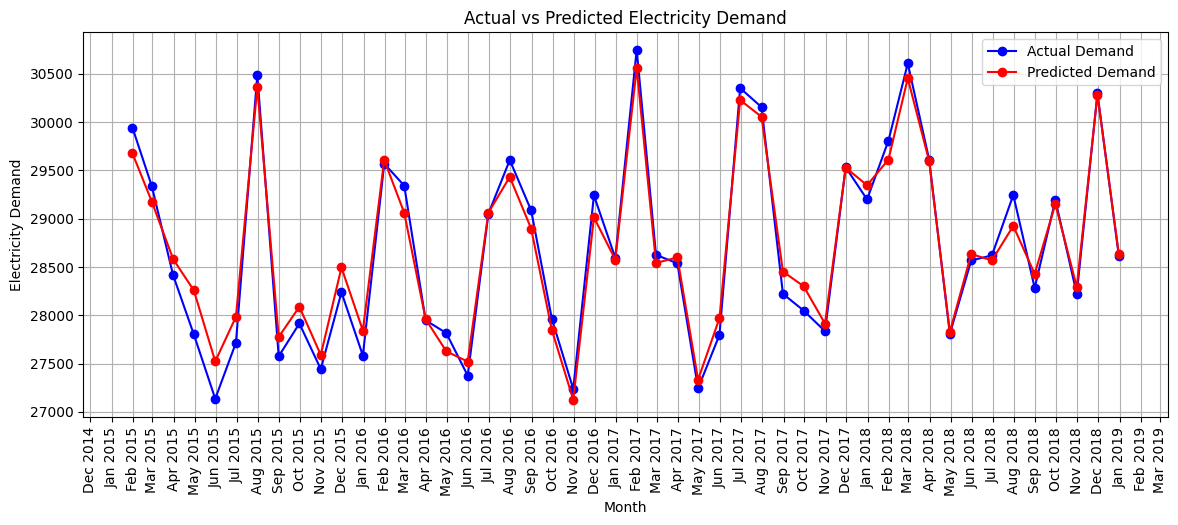

In [164]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Demand (Random Forest (tuning))", ['bold']))

test_indices = X_test_demand.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_rf_tun})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Demand', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Demand', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


**Train a Random Forest(tuning) model to predict price**

In [166]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform Grid Search with cross-validation
with parallel_backend('threading'):
    grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                                  cv=5, n_jobs=1, scoring='neg_mean_squared_error', verbose=2)

# Fit the model
grid_search_rf.fit(X_train_price, y_train_price.ravel())

# Get the best parameters and the best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
print("Best parameters for Random Forest:", best_params_rf)
print("Best score for Random Forest:", best_score_rf)

# Use the best estimator to make predictions
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_tun = best_rf_model.predict(X_test_price)

# Calculate MAPE
mape_rf_tun_p = mean_absolute_percentage_error(y_test_price, y_pred_rf_tun)
print(f'Random Forest(tuning) MAPE for price: {mape_rf_tun_p * 100:.2f}%')
# Calculate MAE
mae_rf_tun_p = mean_absolute_error(y_test_price, y_pred_rf_tun)
print(f'Random Forest(tuning) MAE for price: {mae_rf_tun_p:.2f}')
# Calculate RMSE
rmse_rf_tun_p = np.sqrt(mean_squared_error(y_test_price, y_pred_rf_tun))
print(f'Random Forest(tuning) RMSE for price: {rmse_rf_tun_p:.2f}')
# Calculate R^2
r2_rf_tun_p = r2_score(y_test_price, y_pred_rf_tun)
print(f'Random Forest(tuning) R2 for price: {r2_rf_tun_p:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_rf_tun_p = adjusted_r2_score(r2_rf_tun, X_train_price.shape[0], X_train_price.shape[1])
print(f'Random Forest(tuning) Adjusted R2 for price: {adjusted_r2_rf_tun_p:.2f}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  18.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  19.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  18.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  20.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  19.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  37.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  36.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  40.2s
[CV] END

**Actual vs Predicted Electricity Price (Random Forest(tuning))**


Actual vs Predicted Electricity Price (Random Forest(tuning))


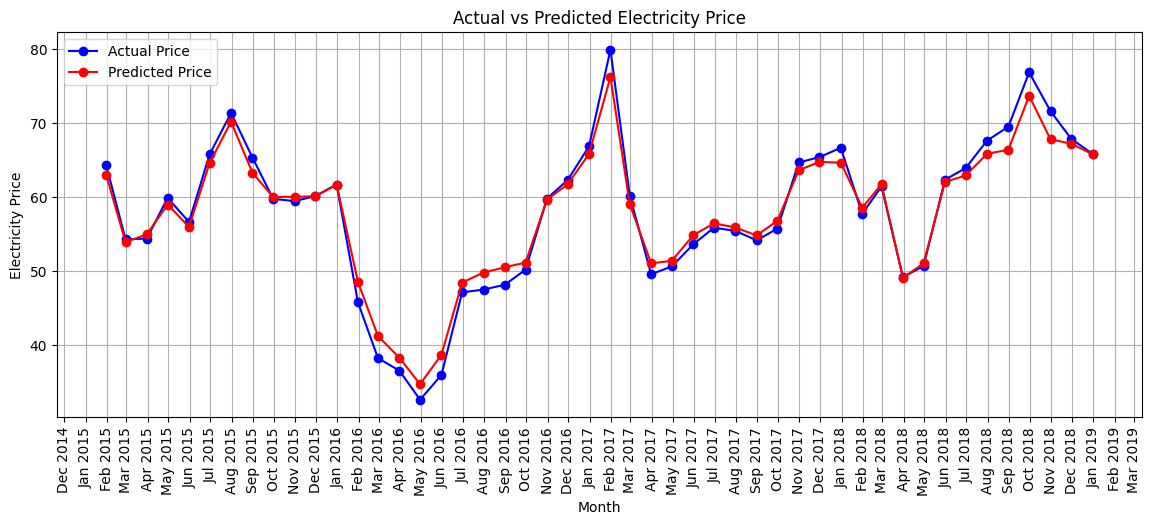

In [167]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Price (Random Forest(tuning))", ['bold']))

test_indices = X_test_price.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_rf_tun})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


# **Gradient Boosting**

**Gradient Boosting for demand**

In [169]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test_demand)

# Calculate MAPE
mape_gb = mean_absolute_percentage_error(y_test_demand, y_pred_gb)
print(f'Gradient Boosting MAPE for demand: {mape_gb * 100:.2f}%')
# Calculate MAE
mae_gb = mean_absolute_error(y_test_demand, y_pred_gb)
print(f'Gradient Boosting MAE for demand: {mae_gb:.2f}')
# Calculate RMSE
rmse_gb = np.sqrt(mean_squared_error(y_test_demand, y_pred_gb))
print(f'Gradient Boosting RMSE for demand: {rmse_gb:.2f}')
# Calculate R^2
r2_gb = r2_score(y_test_demand, y_pred_gb)
print(f'Gradient Boosting R2 for demand: {r2_gb:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_gb = adjusted_r2_score(r2_gb, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'Gradient Boosting Adjusted R2 for demand: {adjusted_r2_gb:.2f}')


Gradient Boosting MAPE for demand: 3.46%
Gradient Boosting MAE for demand: 972.93
Gradient Boosting RMSE for demand: 1253.70
Gradient Boosting R2 for demand: 0.92
Gradient Boosting Adjusted R2 for demand: 0.92


**Actual vs Predicted Electricity Demand (Gradient Boosting)**


Actual vs Predicted Electricity Demand (Gradient Boosting)


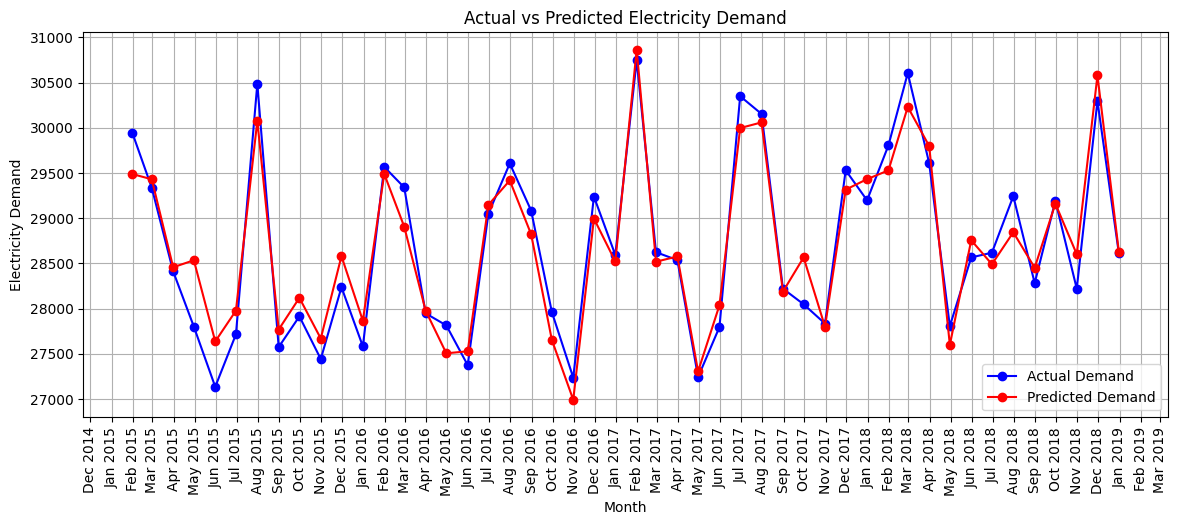

In [170]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Demand (Gradient Boosting)", ['bold']))

test_indices = X_test_demand.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_gb})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Demand', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Demand', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


**Gradient Boosting for price**

In [172]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test_price)

# Calculate MAPE
mape_gb_p = mean_absolute_percentage_error(y_test_price, y_pred_gb)
print(f'Gradient Boosting MAPE for price: {mape_gb_p * 100:.2f}%')
# Calculate MAE
mae_gb_p = mean_absolute_error(y_test_price, y_pred_gb)
print(f'Gradient Boosting MAE for price: {mae_gb_p:.2f}')
# Calculate RMSE
rmse_gb_p = np.sqrt(mean_squared_error(y_test_price, y_pred_gb))
print(f'Gradient Boosting RMSE for price: {rmse_gb_p:.2f}')
# Calculate R^2
r2_gb_p = r2_score(y_test_price, y_pred_gb)
print(f'Gradient Boosting R2 for price: {r2_gb_p:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_gb_p = adjusted_r2_score(r2_gb, X_train_price.shape[0], X_train_price.shape[1])
print(f'Gradient Boosting Adjusted R2 for price: {adjusted_r2_gb_p:.2f}')


Gradient Boosting MAPE for price: 11.16%
Gradient Boosting MAE for price: 5.68
Gradient Boosting RMSE for price: 7.36
Gradient Boosting R2 for price: 0.72
Gradient Boosting Adjusted R2 for price: 0.92


**Actual vs Predicted Electricity Price (Gradient Boosting)**


Actual vs Predicted Electricity Price (Gradient Boosting)


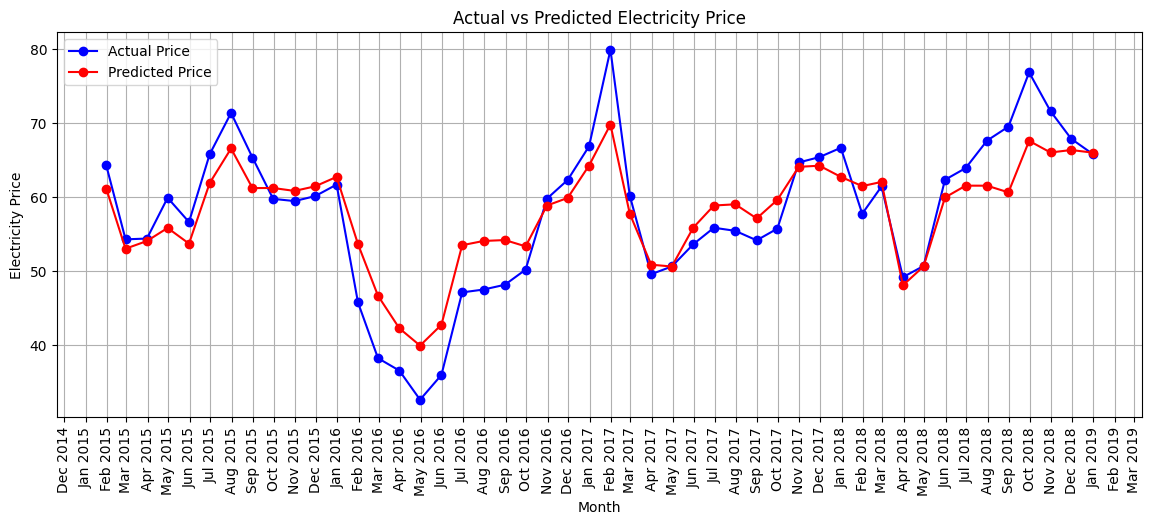

In [173]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Price (Gradient Boosting)", ['bold']))

test_indices = X_test_price.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_gb})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


# **Gradient Boosting with Parameter Tuning**

**Gradient Boosting(tuning) model to predict demand**

In [175]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Perform Grid Search with cross-validation
with parallel_backend('threading'):
    grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb,
                                  cv=5, n_jobs=1, scoring='neg_mean_squared_error', verbose=2)

# Fit the model
grid_search_gb.fit(X_train_demand, y_train_demand.ravel())

# Get the best parameters and the best score
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_
print("Best parameters for Gradient Boosting:", best_params_gb)
print("Best score for Gradient Boosting:", best_score_gb)

# Use the best estimator to make predictions
best_gb_model = grid_search_gb.best_estimator_
y_pred_gb_tun = best_gb_model.predict(X_test_demand)

# Calculate MAPE
mape_gb_tun = mean_absolute_percentage_error(y_test_demand, y_pred_gb_tun)
print(f'Gradient Boosting(tuning) MAPE for demand: {mape_gb_tun * 100:.2f}%')
# Calculate MAE
mae_gb_tun = mean_absolute_error(y_test_demand, y_pred_gb_tun)
print(f'Gradient Boosting(tuning) MAE for demand: {mae_gb_tun:.2f}')
# Calculate RMSE
rmse_gb_tun = np.sqrt(mean_squared_error(y_test_demand, y_pred_gb_tun))
print(f'Gradient Boosting(tuning) RMSE for demand: {rmse_gb_tun:.2f}')
# Calculate R^2
r2_gb_tun = r2_score(y_test_demand, y_pred_gb_tun)
print(f'Gradient Boosting(tuning) R2 for demand: {r2_gb_tun:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_gb_tun = adjusted_r2_score(r2_gb_tun, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'Gradient Boosting(tuning) Adjusted R2 for demand: {adjusted_r2_gb_tun:.2f}')

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   7.8s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   7.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   8.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   6.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   7.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   7.7s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   8.8s
[CV] EN

**Actual vs Predicted Electricity Demand (Gradient Boosting(tuning))**

Actual vs Predicted Electricity Demand (Gradient Boosting(tuning))


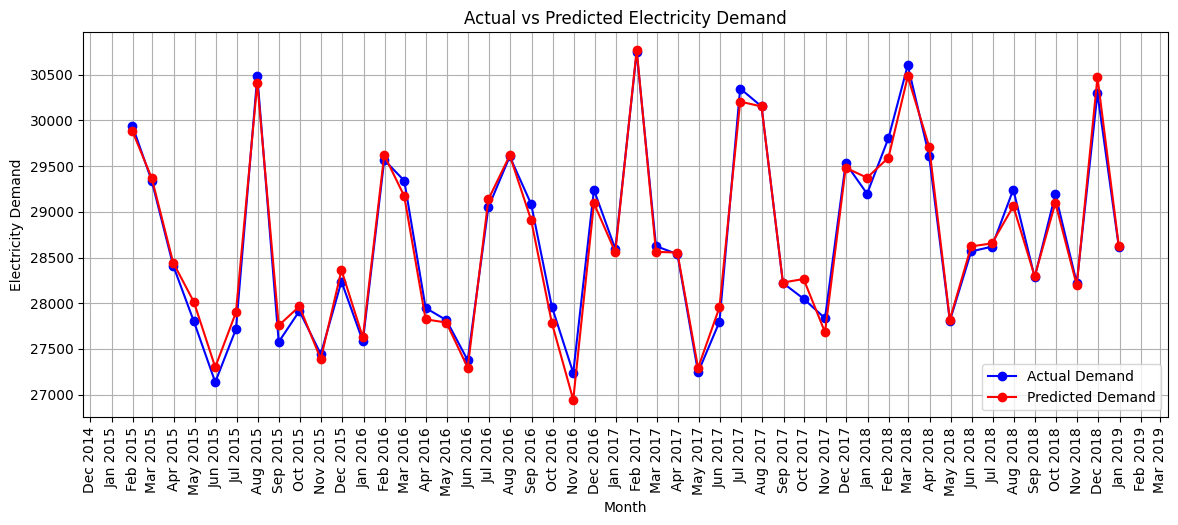

In [176]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Demand (Gradient Boosting(tuning))", ['bold']))

test_indices = X_test_demand.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_demand, 'Predicted': y_pred_gb_tun})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Demand', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Demand', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


**Gradient Boosting(tuning) model to predict price**

In [178]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Perform Grid Search with cross-validation
with parallel_backend('threading'):
    grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb,
                                  cv=5, n_jobs=1, scoring='neg_mean_squared_error', verbose=2)

# Fit the model
grid_search_gb.fit(X_train_price, y_train_price.ravel())

# Get the best parameters and the best score
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_
print("Best parameters for Gradient Boosting:", best_params_gb)
print("Best score for Gradient Boosting:", best_score_gb)

# Use the best estimator to make predictions
best_gb_model = grid_search_gb.best_estimator_
y_pred_gb_tun = best_gb_model.predict(X_test_price)

# Calculate MAPE
mape_gb_tun_p = mean_absolute_percentage_error(y_test_price, y_pred_gb_tun)
print(f'Gradient Boosting(tuning) MAPE for price: {mape_gb_tun_p * 100:.2f}%')
# Calculate MAE
mae_gb_tun_p = mean_absolute_error(y_test_price, y_pred_gb_tun)
print(f'Gradient Boosting(tuning) MAE for price: {mae_gb_tun_p:.2f}')
# Calculate RMSE
rmse_gb_tun_p = np.sqrt(mean_squared_error(y_test_price, y_pred_gb_tun))
print(f'Gradient Boosting(tuning) RMSE for price: {rmse_gb_tun_p:.2f}')
# Calculate R^2
r2_gb_tun_p = r2_score(y_test_price, y_pred_gb_tun)
print(f'Gradient Boosting(tuning) R2 for price: {r2_gb_tun_p:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_gb_tun_p = adjusted_r2_score(r2_gb_tun_p, X_train_price.shape[0], X_train_price.shape[1])
print(f'Gradient Boosting(tuning) Adjusted R2 for price: {adjusted_r2_gb_tun_p:.2f}')

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   6.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   8.7s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   6.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   7.6s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=0.8; total time=   6.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   8.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, subsample=1.0; total time=   8.5s
[CV] EN

**Actual vs Predicted Electricity Price (Gradient Boosting(tuning))**

Actual vs Predicted Electricity Price (Gradient Boosting(tuning))


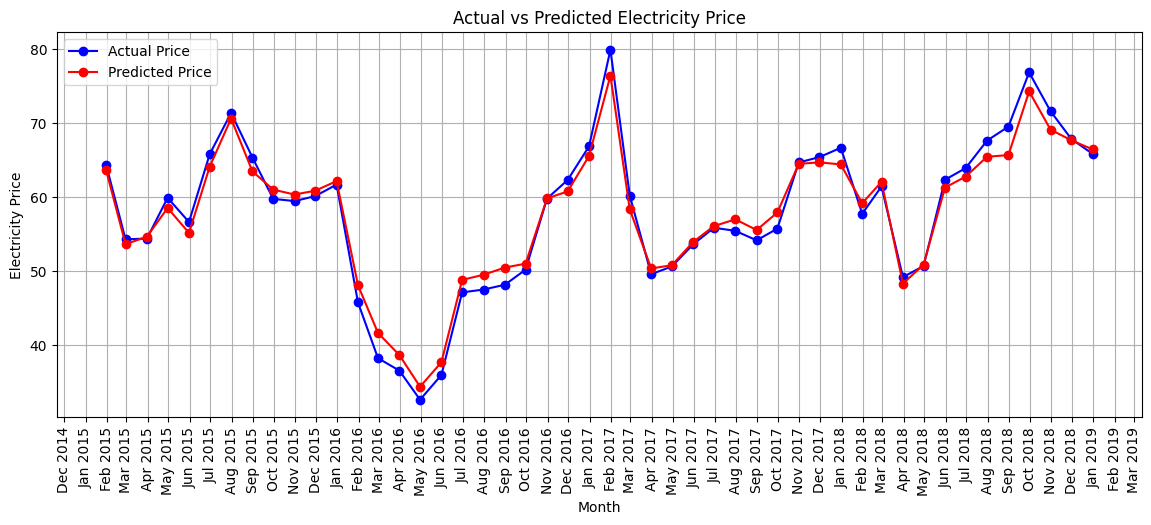

In [179]:
#Actual vs Predicted Electricity Demand
print(colored("Actual vs Predicted Electricity Price (Gradient Boosting(tuning))", ['bold']))

test_indices = X_test_price.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_price, 'Predicted': y_pred_gb_tun})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


# **Long Short-Term Memory (LSTM)**

**Train a LSTM model to predict demand**

In [228]:
# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(features_demand)
# Convert the Series to a NumPy array before reshaping
y_scaled = scaler_y.fit_transform(target_demand.values.reshape(-1, 1))

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 50)             20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 40451 (158.01 KB)
Trainable params: 40451 (158.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Train the Model**

In [229]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
702/702 [==============================] - 9s 6ms/step - loss: 0.1340 - val_loss: 0.0558
Epoch 2/50
702/702 [==============================] - 4s 6ms/step - loss: 0.0570 - val_loss: 0.0469
Epoch 3/50
702/702 [==============================] - 4s 5ms/step - loss: 0.0505 - val_loss: 0.0459
Epoch 4/50
702/702 [==============================] - 3s 5ms/step - loss: 0.0461 - val_loss: 0.0399
Epoch 5/50
702/702 [==============================] - 3s 5ms/step - loss: 0.0427 - val_loss: 0.0382
Epoch 6/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0402 - val_loss: 0.0356
Epoch 7/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0375 - val_loss: 0.0370
Epoch 8/50
702/702 [==============================] - 3s 5ms/step - loss: 0.0358 - val_loss: 0.0323
Epoch 9/50
702/702 [==============================] - 4s 6ms/step - loss: 0.0344 - val_loss: 0.0333
Epoch 10/50
702/702 [==============================] - 4s 6ms/step - loss: 0.0331 - val_loss: 0.0329

In [230]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Calculate MAPE
mape_LSTM = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f'LSTM MAPE for demand: {mape_LSTM * 100:.2f}%')
# Calculate MAE
mae_LSTM = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'LSTM MAE for demand: {mae_LSTM:.2f}')
# Calculate RMSE
rmse_LSTM = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'LSTM RMSE for demand: {rmse_LSTM:.2f}')
# Calculate R^2
r2_LSTM = r2_score(y_test_rescaled, y_pred_rescaled)
print(f'LSTM R2 for demand: {r2_LSTM:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_LSTM = adjusted_r2_score(r2_LSTM, X_train.shape[0], X_train.shape[1])
print(f'LSTM Adjusted R2 for demand: {adjusted_r2_LSTM:.2f}')



220/220 [==============================] - 1s 2ms/step
LSTM MAPE for demand: 1.83%
LSTM MAE for demand: 512.73
LSTM RMSE for demand: 680.12
LSTM R2 for demand: 0.98
LSTM Adjusted R2 for demand: 0.98


**Actual vs Predicted Electricity demand (LSTM)**


Actual vs Predicted Electricity demand (LSTM)


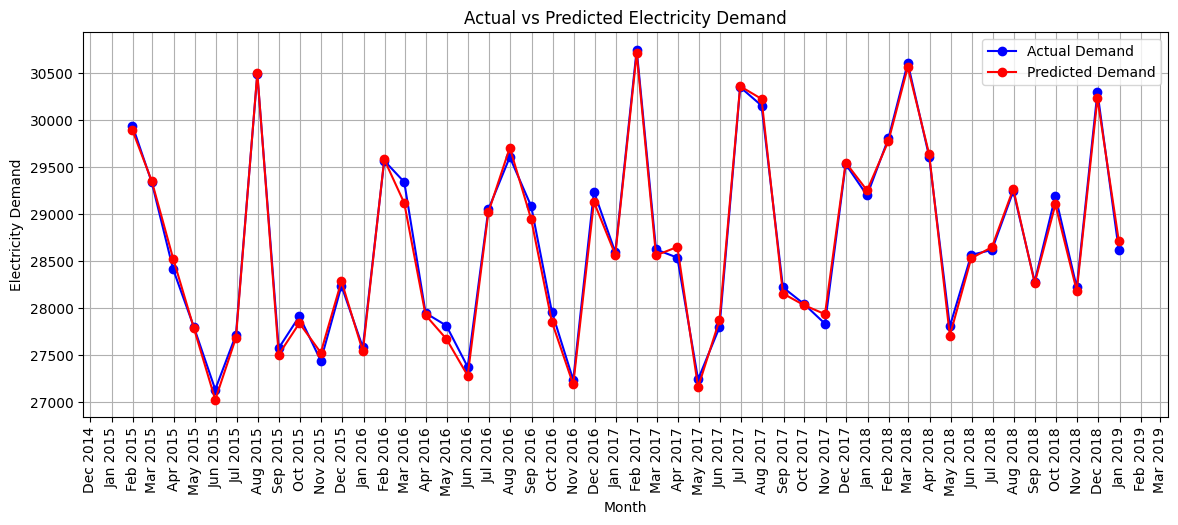

In [231]:
#Actual vs Predicted Electricity Price
print(colored("Actual vs Predicted Electricity demand (LSTM)", ['bold']))
test_indices = X_test_demand.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Reshape y_test_rescaled and y_pred_rescaled to 1D arrays if necessary
y_test_rescaled = y_test_rescaled.ravel()  # Use ravel() to flatten the array
y_pred_rescaled = y_pred_rescaled.ravel()  # Use ravel() to flatten the array

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_rescaled, 'Predicted': y_pred_rescaled})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Demand', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Demand', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


**Train a LSTM model to predict price**

In [233]:
# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(features_price)
# Convert the Series to a NumPy array before reshaping
y_scaled = scaler_y.fit_transform(target_price.values.reshape(-1, 1))

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 50)             20200     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 40451 (158.01 KB)
Trainable params: 40451 (158.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Train the Model**

In [234]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
702/702 [==============================] - 9s 7ms/step - loss: 0.3596 - val_loss: 0.2212
Epoch 2/50
702/702 [==============================] - 3s 5ms/step - loss: 0.1891 - val_loss: 0.1684
Epoch 3/50
702/702 [==============================] - 3s 5ms/step - loss: 0.1513 - val_loss: 0.1421
Epoch 4/50
702/702 [==============================] - 5s 7ms/step - loss: 0.1293 - val_loss: 0.1318
Epoch 5/50
702/702 [==============================] - 3s 5ms/step - loss: 0.1149 - val_loss: 0.1177
Epoch 6/50
702/702 [==============================] - 3s 5ms/step - loss: 0.1065 - val_loss: 0.1106
Epoch 7/50
702/702 [==============================] - 3s 5ms/step - loss: 0.0983 - val_loss: 0.1071
Epoch 8/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0921 - val_loss: 0.1005
Epoch 9/50
702/702 [==============================] - 3s 5ms/step - loss: 0.0863 - val_loss: 0.0942
Epoch 10/50
702/702 [==============================] - 4s 5ms/step - loss: 0.0825 - val_loss: 0.0923

In [235]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Calculate MAPE
mape_LSTM_p = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f'LSTM MAPE for price: {mape_LSTM_p * 100:.2f}%')
# Calculate MAE
mae_LSTM_p = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'LSTM MAE for price: {mae_LSTM_p:.2f}')
# Calculate RMSE
rmse_LSTM_p = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'LSTM RMSE for price: {rmse_LSTM_p:.2f}')
# Calculate R^2
r2_LSTM_p = r2_score(y_test_rescaled, y_pred_rescaled)
print(f'LSTM R2 for price: {r2_LSTM_p:.2f}')
# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_LSTM_p = adjusted_r2_score(r2_LSTM, X_train.shape[0], X_train.shape[1])
print(f'LSTM Adjusted R2 for price: {adjusted_r2_LSTM_p:.2f}')


220/220 [==============================] - 1s 2ms/step
LSTM MAPE for price: 5.14%
LSTM MAE for price: 2.71
LSTM RMSE for price: 3.76
LSTM R2 for price: 0.93
LSTM Adjusted R2 for price: 0.98


**Actual vs Predicted Electricity Price (LSTM)**

Actual vs Predicted Electricity Price (LSTM)


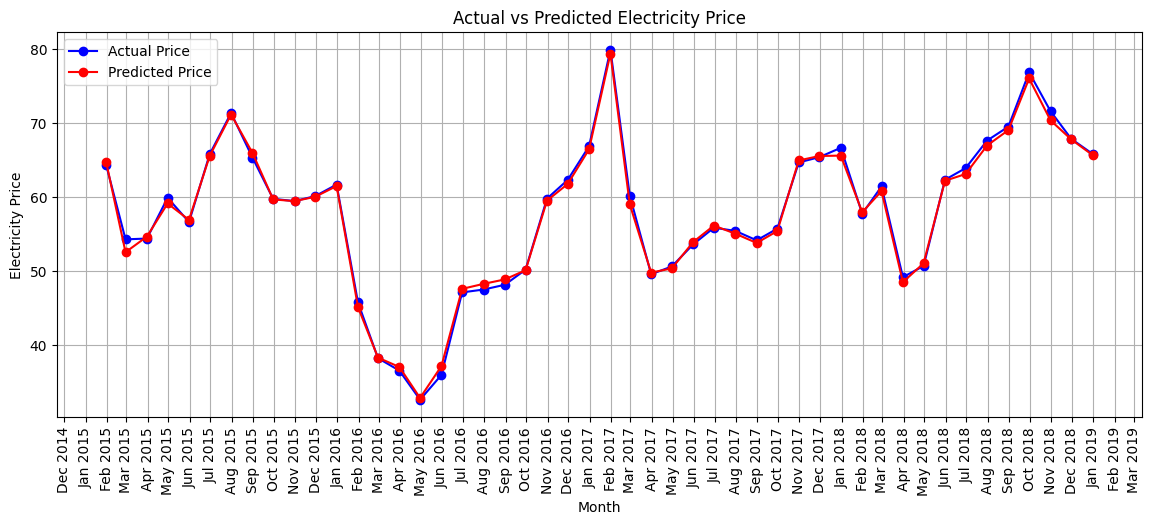

In [236]:
#Actual vs Predicted Electricity Price
print(colored("Actual vs Predicted Electricity Price (LSTM)", ['bold']))
test_indices = X_test_price.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Reshape y_test_rescaled and y_pred_rescaled to 1D arrays if necessary
y_test_rescaled = y_test_rescaled.ravel()  # Use ravel() to flatten the array
y_pred_rescaled = y_pred_rescaled.ravel()  # Use ravel() to flatten the array

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_rescaled, 'Predicted': y_pred_rescaled})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


# **Compare the performance of each model**

#**Electricity Demand**

In [190]:
# Create a dictionary of the results
results = {
    "Model": ["Linear Regression","Decision Tree", "Random Forest","Random Forest(tuning)", "Gradient Boosting",
              "Gradient Boosting(tuning)","Long Short-Term Memory"],
    "MAPE": [mape_lr,mape_dt, mape_rf,mape_rf_tun, mape_gb,mape_gb_tun,mape_LSTM],
    "MAE": [mae_lr,mae_dt, mae_rf,mae_rf_tun, mae_gb,mae_gb_tun,mae_LSTM],
    "RMSE": [rmse_lr,rmse_dt, rmse_rf,rmse_rf_tun, rmse_gb,rmse_gb_tun,rmse_LSTM],
    "R²": [r2_lr,r2_dt, r2_rf,r2_rf_tun, r2_gb,r2_gb_tun,r2_LSTM],
    "Adjusted R²": [adjusted_r2_lr,adjusted_r2_dt, adjusted_r2_rf,adjusted_r2_rf_tun, adjusted_r2_gb,adjusted_r2_gb_tun,adjusted_r2_LSTM]
}


# Convert the dictionary into a DataFrame
results_df = pd.DataFrame(results)

# Display the results table
print("Performance Table for Demand model")
results_df

Performance Table for Demand model


Model      MAPE          MAE         RMSE        R²  \
0          Linear Regression  0.035078   988.427519  1270.093525  0.922603   
1              Decision Tree  0.038433  1078.999287  1546.341479  0.885273   
2              Random Forest  0.024693   689.001917   939.227423  0.957675   
3      Random Forest(tuning)  0.024813   692.695315   942.003647  0.957425   
4          Gradient Boosting  0.034585   972.933374  1253.700469  0.924588   
5  Gradient Boosting(tuning)  0.023629   667.386833   863.987165  0.964185   
6     Long Short-Term Memory  0.019154   536.838324   719.495328  0.975162   

   Adjusted R²  
0     0.922465  
1     0.885068  
2     0.957600  
3     0.957349  
4     0.924453  
5     0.964121  
6     0.975161

**FOr Demand:- Long Short-Term Memory model is better compared to other model as it has the least  MAPE,MAE,RMSE and best R² value**
**

#**Electricity Price**

In [206]:
# Create a dictionary of the results
results = {
    "Model": ["Linear Regression","Decision Tree", "Random Forest","Random Forest(tuning)", "Gradient Boosting",
              "Gradient Boosting(tuning)","Long Short-Term Memory"],
    "MAPE": [mape_lr_p,mape_dt_p, mape_rf_p,mape_rf_tun_p, mape_gb_p,mape_gb_tun_p,mape_LSTM_p],
    "MAE": [mae_lr_p,mae_dt_p, mae_rf_p,mae_rf_tun_p, mae_gb_p,mae_gb_tun_p,mae_LSTM_p],
    "RMSE": [rmse_lr_p,rmse_dt_p, rmse_rf_p,rmse_rf_tun_p, rmse_gb_p,rmse_gb_tun_p,rmse_LSTM_p],
    "R²": [r2_lr_p,r2_dt_p, r2_rf_p,r2_rf_tun_p, r2_gb_p,r2_gb_tun_p,r2_LSTM_p],
    "Adjusted R²": [adjusted_r2_lr_p,adjusted_r2_dt_p, adjusted_r2_rf_p,adjusted_r2_rf_tun_p, adjusted_r2_gb_p,adjusted_r2_gb_tun_p,adjusted_r2_LSTM_p]
}

# Convert the dictionary into a DataFrame
results_df = pd.DataFrame(results)

# Display the results table
print("Performance Table for Price model")
results_df

Performance Table for Price model


Model      MAPE       MAE      RMSE        R²  \
0          Linear Regression  0.144510  7.359438  9.405719  0.547238   
1              Decision Tree  0.080660  4.242130  6.900054  0.756336   
2              Random Forest  0.056651  2.904602  4.184541  0.910385   
3      Random Forest(tuning)  0.058543  3.006241  4.282012  0.906161   
4          Gradient Boosting  0.111616  5.682892  7.356066  0.723065   
5  Gradient Boosting(tuning)  0.069100  3.619701  4.754859  0.884293   
6     Long Short-Term Memory  0.049218  2.611849  3.571432  0.934721   

   Adjusted R²  
0     0.546429  
1     0.885068  
2     0.957600  
3     0.957349  
4     0.924453  
5     0.884086  
6     0.975161

**For Price:-Long Short-Term Memory M:odel is better compared to other model as it has the least  MAPE,MAE,RMSE and best R² value**


# **Feature Importance**


Important Variable for Demand model


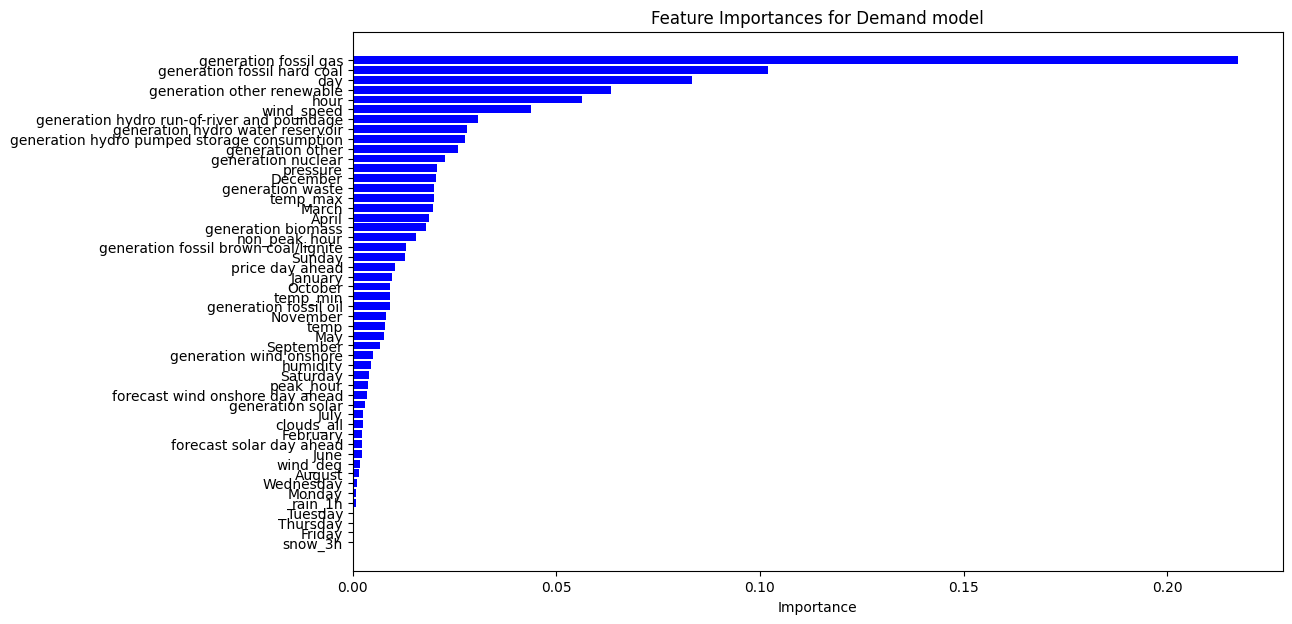

Important Variable for Price model


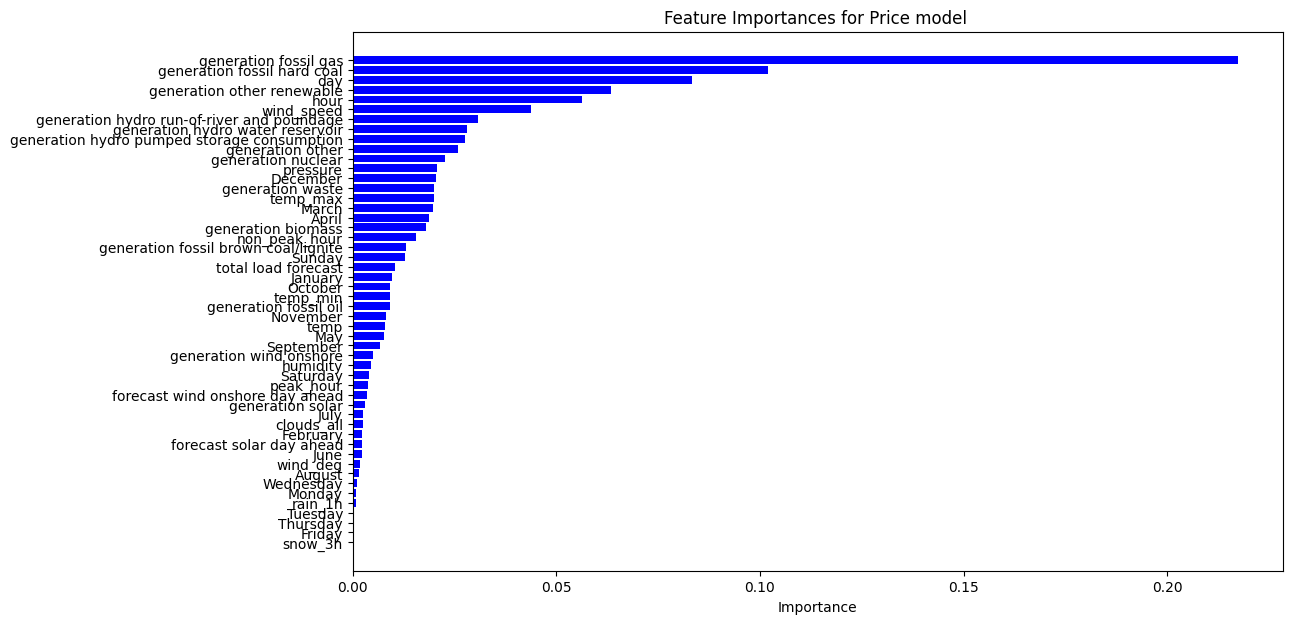

Important Variable for Demand model
peak_hour, non_peak_hour,hour,generation fossil oil,temp, temp_min, temp_max,Sunday,Saturday,April,March,May,pressure, humidity, wind_speed
Important Variable for Price model
peak_hour, non_peak_hour,hour,generation other renewable,temp, temp_min, temp_max,Sunday,Saturday,April,January,October,pressure, humidity, wind_speed


In [199]:
#Important Variable
print("\033[1mImportant Variable for Demand model\033[0m") # Use ANSI escape codes for bold text

importances = best_gb_model.feature_importances_
features = X_train_demand.columns

# Get the indices that would sort the importances array
sorted_indices = np.argsort(importances)

# Sort the importances and features based on the sorted indices
sorted_importances = importances[sorted_indices]
sorted_features = features[sorted_indices]

plt.figure(figsize=(12, 7))
plt.barh(sorted_features, sorted_importances, color='blue')
plt.title('Feature Importances for Demand model')
plt.xlabel('Importance')
plt.show()


print("\033[1mImportant Variable for Price model\033[0m") # Use ANSI escape codes for bold text
importances = best_gb_model.feature_importances_
features = X_train_price.columns

# Get the indices that would sort the importances array
sorted_indices = np.argsort(importances)

# Sort the importances and features based on the sorted indices
sorted_importances = importances[sorted_indices]
sorted_features = features[sorted_indices]

plt.figure(figsize=(12, 7))
plt.barh(sorted_features, sorted_importances, color='blue')
plt.title('Feature Importances for Price model ')
plt.xlabel('Importance')
plt.show()

print("\033[1mImportant Variable for Demand model\033[0m") # Use ANSI escape codes for bold text
print("peak_hour, non_peak_hour,hour,generation fossil oil,temp, temp_min, temp_max,Sunday,Saturday,April,March,May,pressure, humidity, wind_speed")

print("\033[1mImportant Variable for Price model\033[0m") # Use ANSI escape codes for bold text
print("peak_hour, non_peak_hour,hour,generation other renewable,temp, temp_min, temp_max,Sunday,Saturday,April,January,October,pressure, humidity, wind_speed")

# **Actual vs Predicted**

 **Actual Demand vs Predicted Demand**

Actual vs Predicted Electricity demand (LSTM)


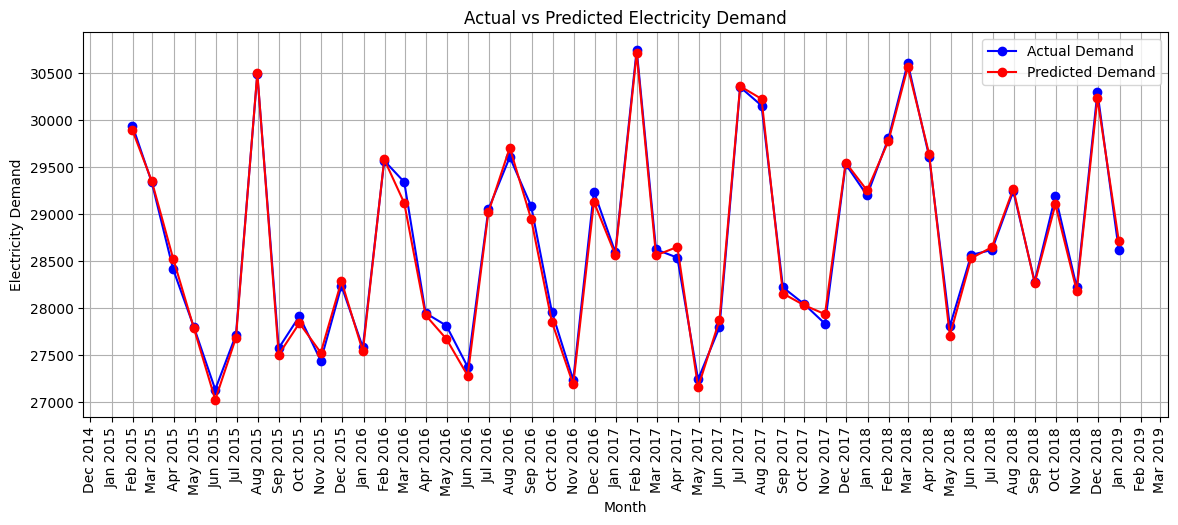

In [232]:
#Actual vs Predicted Electricity Price
print(colored("Actual vs Predicted Electricity demand (LSTM)", ['bold']))
test_indices = X_test_demand.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Reshape y_test_rescaled and y_pred_rescaled to 1D arrays if necessary
y_test_rescaled = y_test_rescaled.ravel()  # Use ravel() to flatten the array
y_pred_rescaled = y_pred_rescaled.ravel()  # Use ravel() to flatten the array

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_rescaled, 'Predicted': y_pred_rescaled})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Demand', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Demand', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


 **Actual Price vs Predicted price**

Actual vs Predicted Electricity Price (LSTM)


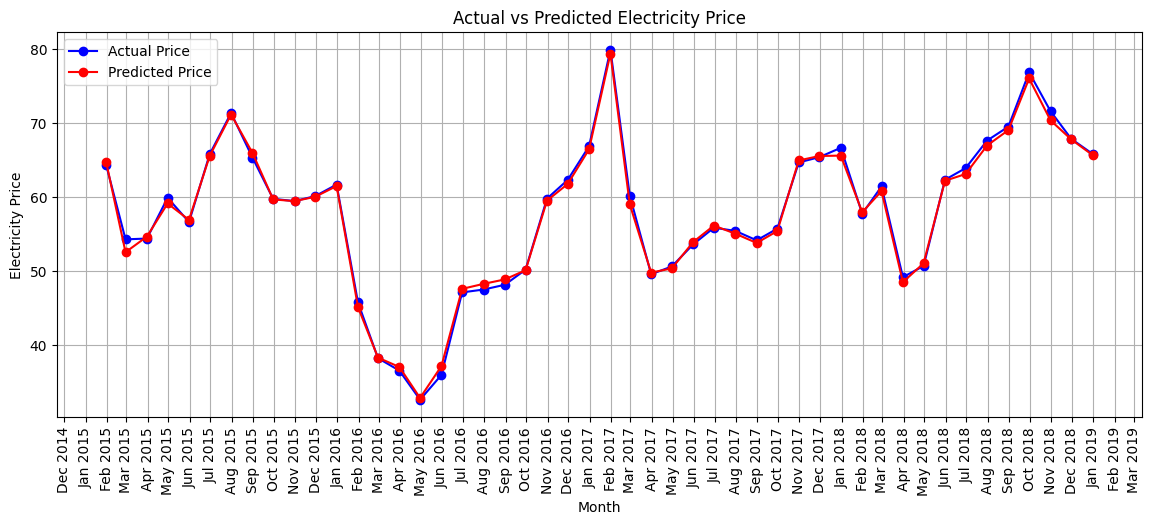

In [237]:
#Actual vs Predicted Electricity Price
print(colored("Actual vs Predicted Electricity Price (LSTM)", ['bold']))
test_indices = X_test_price.index

# Get the corresponding dates for the test set
test_dates = merged_df.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Reshape y_test_rescaled and y_pred_rescaled to 1D arrays if necessary
y_test_rescaled = y_test_rescaled.ravel()  # Use ravel() to flatten the array
y_pred_rescaled = y_pred_rescaled.ravel()  # Use ravel() to flatten the array

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_rescaled, 'Predicted': y_pred_rescaled})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 5))
plt.plot(monthly_results.index, monthly_results['Actual'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.show()


#**Resust**

**Price And Demand Forecasting Long Short-Term Memory Model is better compared to other model as it has the least  MAPE,MAE,RMSE and High R² value, Adjusted R²**
